# Ms. Pacman NSGA-II Analysis

This notebook displays the results from the implementation of NSGA2 genetic algorithm to evolve AI agents for Ms. Pac-Man. The objective is to maximise the score in each objective in the game environment using the OpenAI Gymnasium framework.

In [1]:
# Import necessary libraries
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist
import gymnasium as gym
import ale_py
from gymnasium.wrappers import RecordEpisodeStatistics
from IPython.display import display, clear_output
import time

# Load optimisation results
with open('pacman_nsga2_final_results.pkl', 'rb') as f:
    results = pickle.load(f)

# Extract generation history
generation_history = results['generation_history']

# Configuration from original optimisation
LIMITED_ACTIONS = [1, 2, 3, 4]  # UP, RIGHT, DOWN, LEFT

# Need to update action_names dictionary
action_names = {
    0: "UP",    # Was "NOOP"
    1: "RIGHT", # Was "UP"
    2: "DOWN",  # Was "RIGHT"
    3: "LEFT"   # Was "DOWN", "LEFT" was 4
}

GHOST_SCORE = 200

print("NSGA2 Configuration:")
for key, value in results['config'].items():
    print(f"{key}: {value}")

NSGA2 Configuration:
POPULATION_SIZE: 300
GENERATIONS: 1000
MUTATION_RATE: 0.05
CROSSOVER_RATE: 0.7
SEQUENCE_LENGTH: 10000
LIMITED_ACTIONS: [1, 2, 3, 4]


In [2]:
# Initialise variables to track max score info
max_game_score = 0
max_score_generation = 0
max_score_seed = None
max_score_metrics = None  # Store the full metrics for the best agent
  
# Iterate through generation history
for gen_data in results['generation_history']:
    current_gen = gen_data['generation']
    if 'metrics' in gen_data:  
        metrics_list = gen_data['metrics']
        for metric in metrics_list:
            if metric and metric['total_score'] > max_game_score:
                max_game_score = metric['total_score']
                max_score_generation = current_gen
                max_score_metrics = metric
                max_score_seed = metric.get('seed')  # Get seed directly from metrics

print(f"Maximum game score achieved: {max_game_score:.0f}")
print(f"Generation with max score: {max_score_generation}")
print(f"Seed of max score: {max_score_seed}")

Maximum game score achieved: 4170
Generation with max score: 866
Seed of max score: 189375


In [3]:
# Create DataFrame for evolution analysis
evolution_data = []
for gen in generation_history:
    obj_values = np.array(gen['objective_values'])
    
    # Calculate diversity metrics
    if len(obj_values) > 1:
        spread = np.mean(pdist(obj_values))
        diversity = np.std(pdist(obj_values))
    else:
        spread = 0
        diversity = 0
    
    # Calculate objective statistics
    obj_means = np.mean(obj_values, axis=0)
    obj_max = np.max(obj_values, axis=0)
    
    evolution_data.append({
        'generation': gen['generation'],
        'spread': spread,
        'diversity': diversity,
        'progression_mean': obj_means[0],
        'survival_mean': obj_means[1],
        'efficiency_mean': obj_means[2],
        'progression_max': obj_max[0],
        'survival_max': obj_max[1],
        'efficiency_max': obj_max[2]
    })

evolution_df = pd.DataFrame(evolution_data)
print("Data loaded successfully. Evolution data shape:", evolution_df.shape)
evolution_df.head()

Data loaded successfully. Evolution data shape: (1001, 9)


,generation,spread,diversity,progression_mean,survival_mean,efficiency_mean,progression_max,survival_max,efficiency_max
0,0,0.075290,0.069600,0.169911,0.220797,0.034884,0.315367,0.328906,0.387759
1,0,0.070500,0.075356,0.202865,0.241627,0.039835,0.355500,0.371606,0.387759
2,1,0.079259,0.084730,0.218026,0.250914,0.046877,0.355500,0.371606,0.479677
3,2,0.084741,0.088030,0.228589,0.257535,0.050463,0.355500,0.371606,0.479677
4,3,0.094894,0.090140,0.237356,0.263630,0.058754,0.355500,0.371606,0.479677


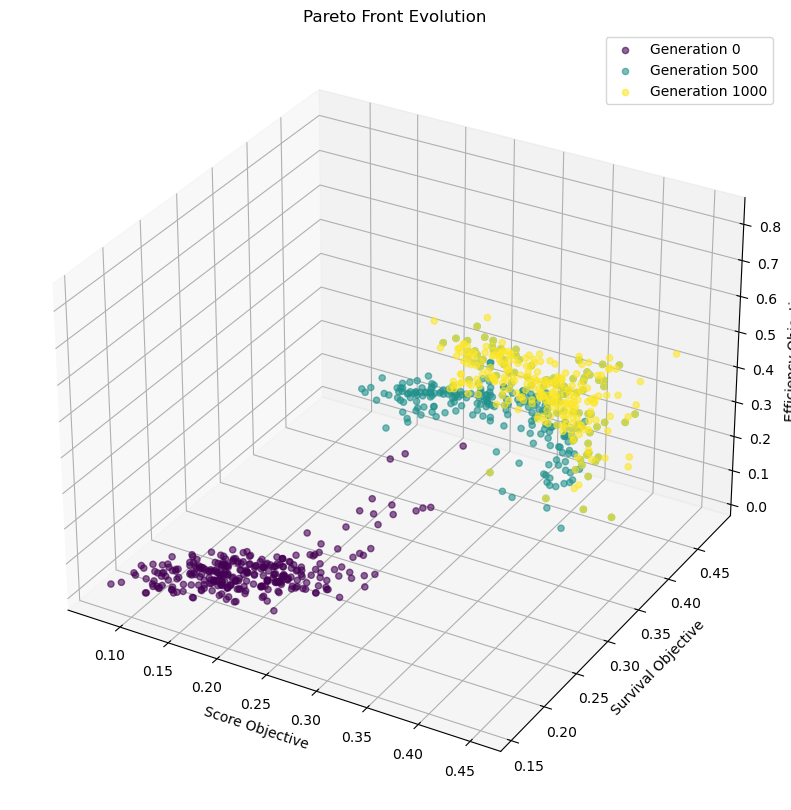

In [4]:
# Analyse Pareto Front Evolution
def plot_pareto_front_3d(generation_history, generations_to_plot):
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    colours = plt.cm.viridis(np.linspace(0, 1, len(generations_to_plot)))
    
    for i, gen_idx in enumerate(generations_to_plot):
        objectives = np.array([list(obj) for obj in generation_history[gen_idx]['objective_values']])
        
        ax.scatter(objectives[:, 0], objectives[:, 1], objectives[:, 2],
                  c=[colours[i]], label=f'Generation {gen_idx}',
                  alpha=0.6)
    
    ax.set_xlabel('Score Objective')
    ax.set_ylabel('Survival Objective')
    ax.set_zlabel('Efficiency Objective')
    ax.legend()
    plt.title('Pareto Front Evolution')
    plt.show()

# Plot first, middle, and last generation
generations_to_plot = [0, len(results['generation_history'])//2, len(results['generation_history'])-1]
plot_pareto_front_3d(results['generation_history'], generations_to_plot)



Evolution Summary Statistics:

Objective Improvements (First to Last Generation):
Progression: 43.2% improvement
Survival: 47.1% improvement
Efficiency: 110.3% improvement


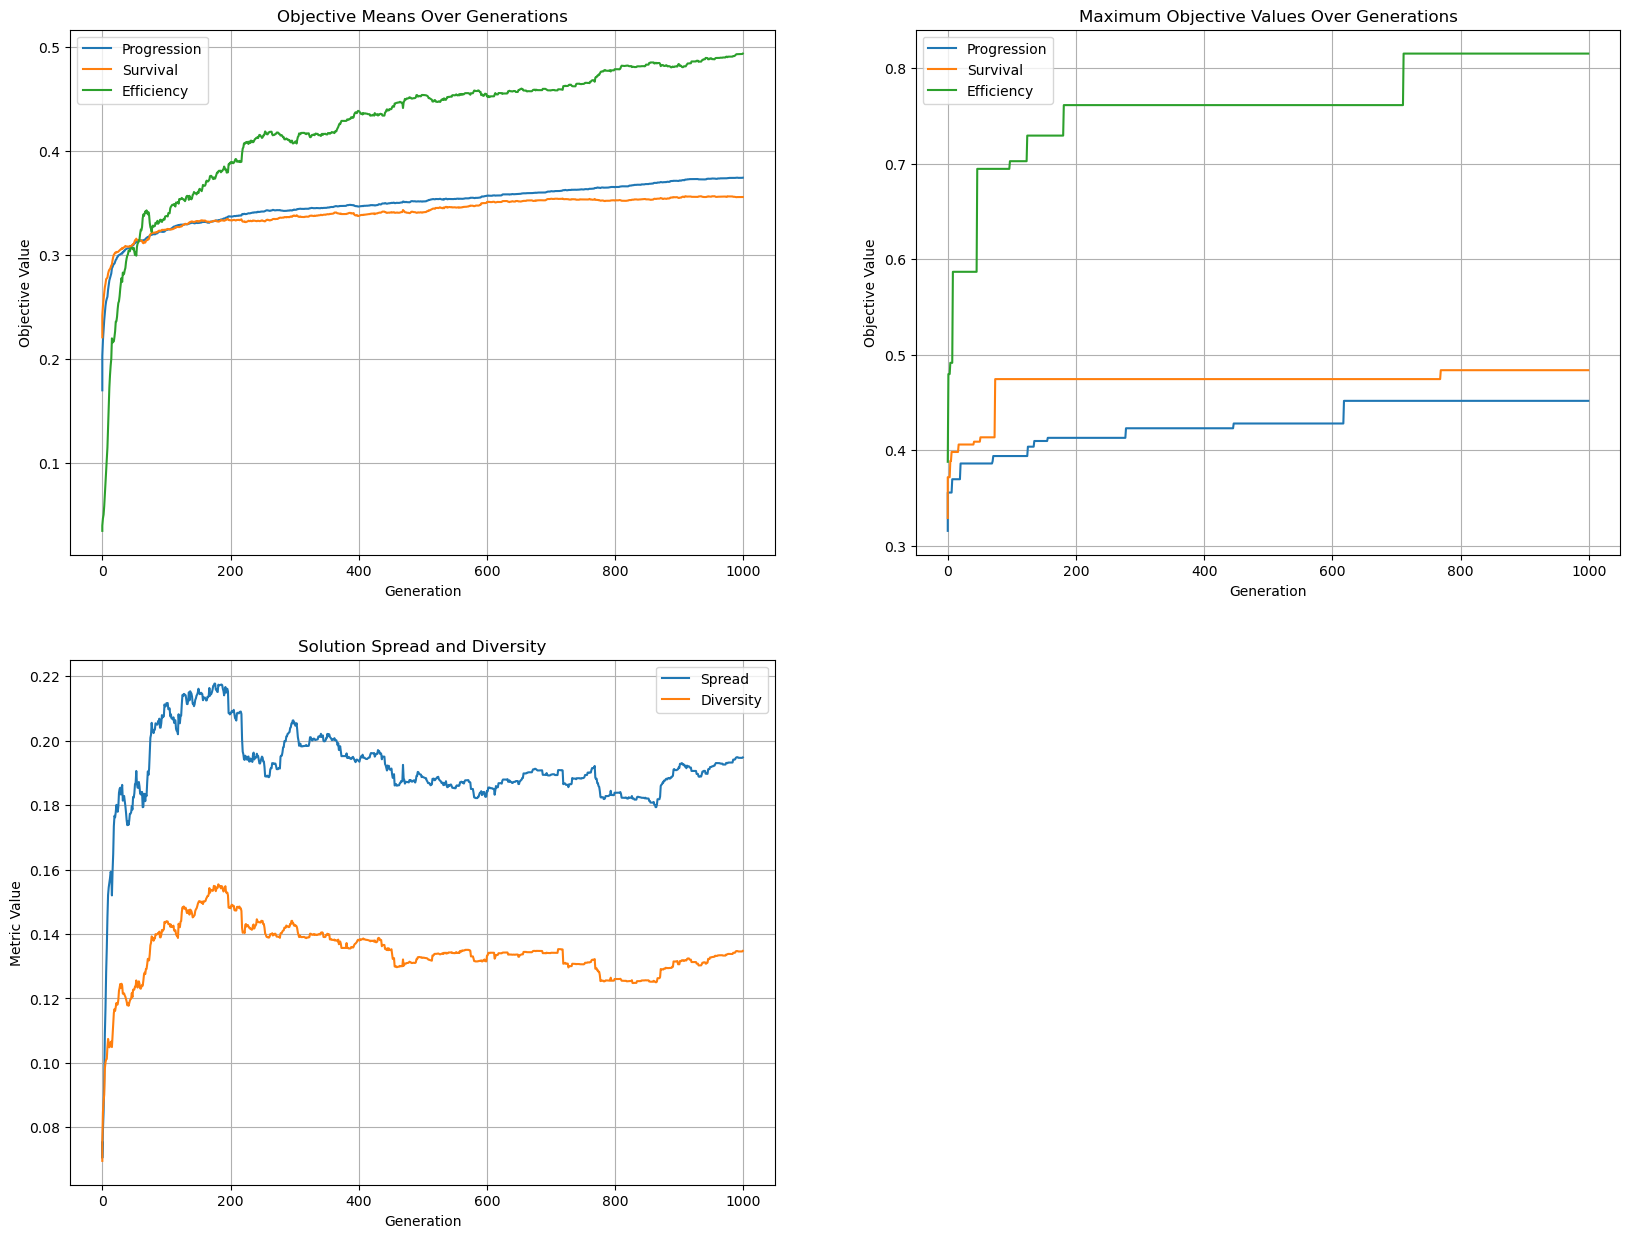

In [5]:
# Create multi-plot figure for evolution analysis
fig = plt.figure(figsize=(20, 15))

# 1. Objective Means Over Generations
ax1 = fig.add_subplot(221)
ax1.plot(evolution_df['generation'], evolution_df['progression_mean'], label='Progression')
ax1.plot(evolution_df['generation'], evolution_df['survival_mean'], label='Survival')
ax1.plot(evolution_df['generation'], evolution_df['efficiency_mean'], label='Efficiency')
ax1.set_title('Objective Means Over Generations')
ax1.set_xlabel('Generation')
ax1.set_ylabel('Objective Value')
ax1.legend()
ax1.grid(True)

# 2. Maximum Values Over Generations
ax2 = fig.add_subplot(222)
ax2.plot(evolution_df['generation'], evolution_df['progression_max'], label='Progression')
ax2.plot(evolution_df['generation'], evolution_df['survival_max'], label='Survival')
ax2.plot(evolution_df['generation'], evolution_df['efficiency_max'], label='Efficiency')
ax2.set_title('Maximum Objective Values Over Generations')
ax2.set_xlabel('Generation')
ax2.set_ylabel('Objective Value')
ax2.legend()
ax2.grid(True)

# 3. Solution Spread and Diversity
ax3 = fig.add_subplot(223)
ax3.plot(evolution_df['generation'], evolution_df['spread'], label='Spread')
ax3.plot(evolution_df['generation'], evolution_df['diversity'], label='Diversity')
ax3.set_title('Solution Spread and Diversity')
ax3.set_xlabel('Generation')
ax3.set_ylabel('Metric Value')
ax3.legend()
ax3.grid(True)

# Print summary statistics
print("\nEvolution Summary Statistics:")
print("\nObjective Improvements (First to Last Generation):")
first_gen = evolution_df.iloc[0]
last_gen = evolution_df.iloc[-1]
print(f"Progression: {((last_gen['progression_max'] / first_gen['progression_max']) - 1) * 100:.1f}% improvement")
print(f"Survival: {((last_gen['survival_max'] / first_gen['survival_max']) - 1) * 100:.1f}% improvement")
print(f"Efficiency: {((last_gen['efficiency_max'] / first_gen['efficiency_max']) - 1) * 100:.1f}% improvement")

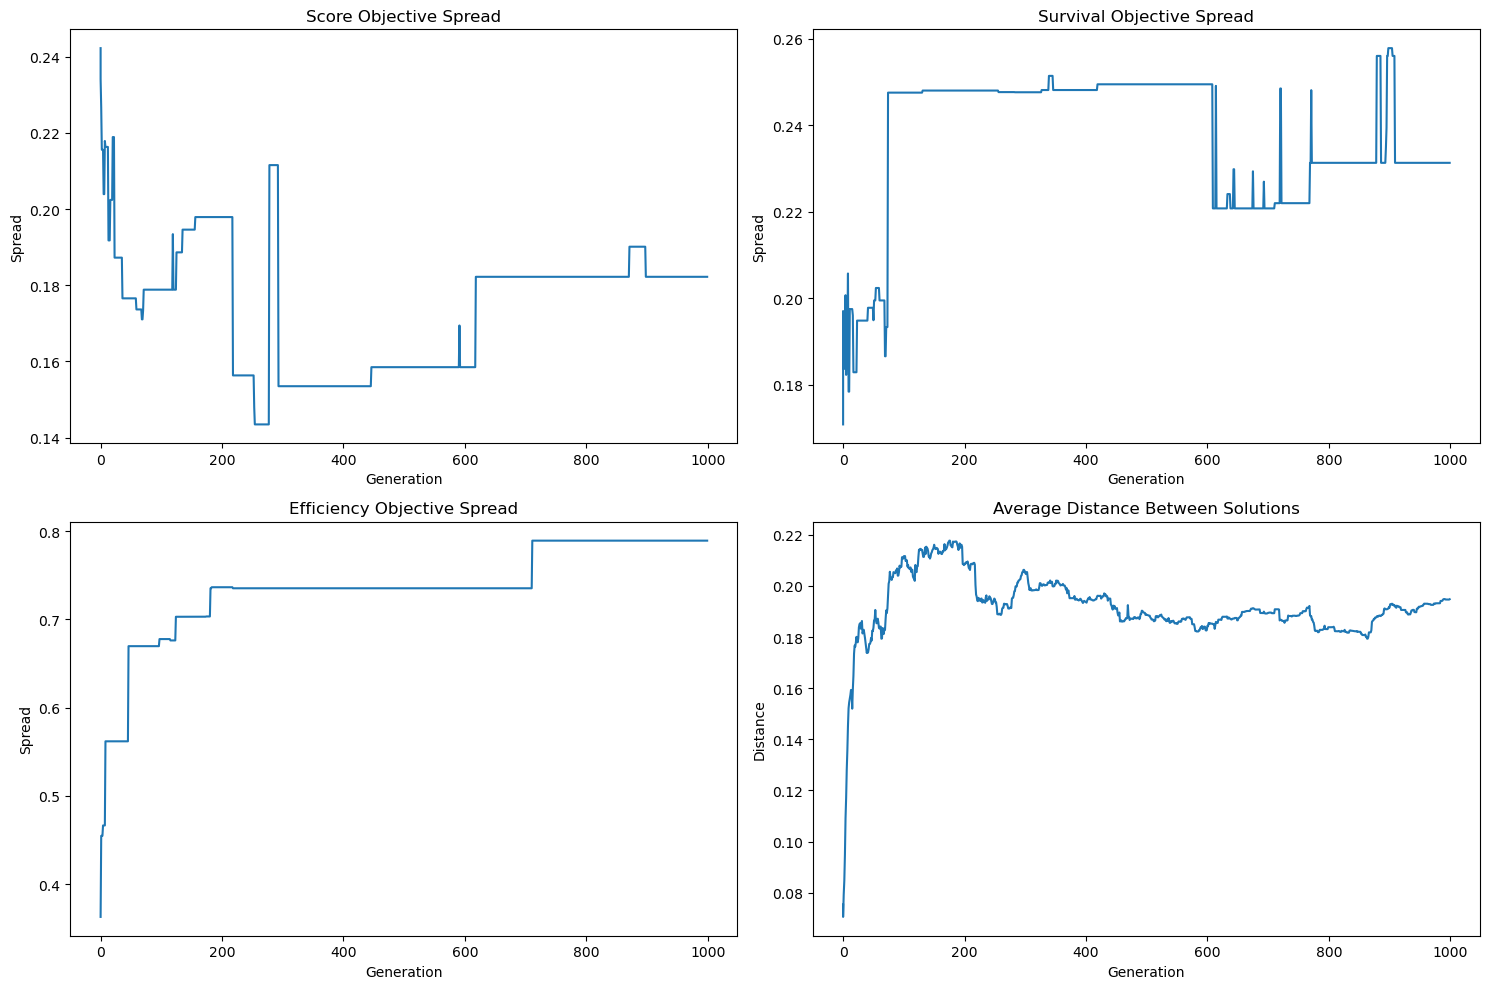

In [6]:
# Solution Diversity Analysis
def analyse_diversity(generation_history):
    diversity_metrics = []
    
    for gen in generation_history:
        objectives = np.array([list(obj) for obj in gen['objective_values']])
        
        # Calculate spread in each objective
        spreads = np.ptp(objectives, axis=0)
        
        # Calculate average distance between solutions
        if len(objectives) > 1:
            distances = []
            for i in range(len(objectives)):
                for j in range(i+1, len(objectives)):
                    distances.append(np.linalg.norm(objectives[i] - objectives[j]))
            avg_distance = np.mean(distances)
        else:
            avg_distance = 0
            
        diversity_metrics.append({
            'generation': gen['generation'],
            'score_spread': spreads[0],
            'survival_spread': spreads[1],
            'efficiency_spread': spreads[2],
            'avg_distance': avg_distance,
            'solution_spread': gen.get('solution_spread', 0)
        })
    
    return pd.DataFrame(diversity_metrics)

diversity_df = analyse_diversity(results['generation_history'])

# Plot diversity metrics
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(diversity_df['generation'], diversity_df['score_spread'])
plt.title('Score Objective Spread')
plt.xlabel('Generation')
plt.ylabel('Spread')

plt.subplot(2, 2, 2)
plt.plot(diversity_df['generation'], diversity_df['survival_spread'])
plt.title('Survival Objective Spread')
plt.xlabel('Generation')
plt.ylabel('Spread')

plt.subplot(2, 2, 3)
plt.plot(diversity_df['generation'], diversity_df['efficiency_spread'])
plt.title('Efficiency Objective Spread')
plt.xlabel('Generation')
plt.ylabel('Spread')

plt.subplot(2, 2, 4)
plt.plot(diversity_df['generation'], diversity_df['avg_distance'])
plt.title('Average Distance Between Solutions')
plt.xlabel('Generation')
plt.ylabel('Distance')

plt.tight_layout()
plt.show()

In [7]:
def analyse_agent_behaviour(agent_data):
    """Analyse detailed behaviour patterns of an agent"""
    action_sequence, seed, fitness_values, metrics = agent_data[:4]
    
    # Calculate scoring patterns
    score_segments = np.array(metrics['score_segments'])
    score_changes = np.diff(score_segments, prepend=0)
    
    # Calculate temporal metrics
    frames_survived = metrics['frames_survived']
    thirds = frames_survived // 3
    
    # Analyse scoring phases
    early_score = sum(score_changes[:thirds//100])
    mid_score = sum(score_changes[thirds//100:(2*thirds)//100])
    late_score = sum(score_changes[(2*thirds)//100:])
    
    # Ghost hunting analysis
    ghost_points = metrics['ghost_points']
    ghost_ratio = ghost_points / max(1, metrics['total_score'])
    
    return {
        'temporal_scoring': {
            'early_game': early_score,
            'mid_game': mid_score,
            'late_game': late_score
        },
        'ghost_hunting': {
            'total_ghost_points': ghost_points,
            'ghost_ratio': ghost_ratio
        },
        'survival_stats': {
            'frames_survived': frames_survived,
            'deaths': metrics['deaths']
        },
        'fitness_values': fitness_values
    }

# Analyse best agents for each objective
best_agents = {
    'progression': results['performance_metrics']['score_objective']['best_individuals'][0],
    'survival': results['performance_metrics']['survival_objective']['best_individuals'][0],
    'efficiency': results['performance_metrics']['efficiency_objective']['best_individuals'][0]
}

# Analyse each best agent
agent_analyses = {obj: analyse_agent_behaviour(agent) for obj, agent in best_agents.items()}

print("Best Agent Analyses:")
for objective, analysis in agent_analyses.items():
    print(f"\n{objective.capitalize()} Specialist:")
    print(f"Fitness Values: {analysis['fitness_values']}")
    print(f"Survival: {analysis['survival_stats']['frames_survived']} frames, {analysis['survival_stats']['deaths']} deaths")
    print(f"Ghost Hunting: {analysis['ghost_hunting']['ghost_ratio']*100:.1f}% of points from ghosts")

Best Agent Analyses:

Progression Specialist:
Fitness Values: (0.4516, 0.3886813953488372, 0.526617946480512)
Survival: 4385 frames, 3 deaths
Ghost Hunting: 78.8% of points from ghosts

Survival Specialist:
Fitness Values: (0.4321, 0.48371714285714285, 0.438119555749129)
Survival: 5681 frames, 3 deaths
Ghost Hunting: 69.7% of points from ghosts

Efficiency Specialist:
Fitness Values: (0.3362333333333334, 0.25239333333333336, 0.8154832413514606)
Survival: 2401 frames, 3 deaths
Ghost Hunting: 92.9% of points from ghosts


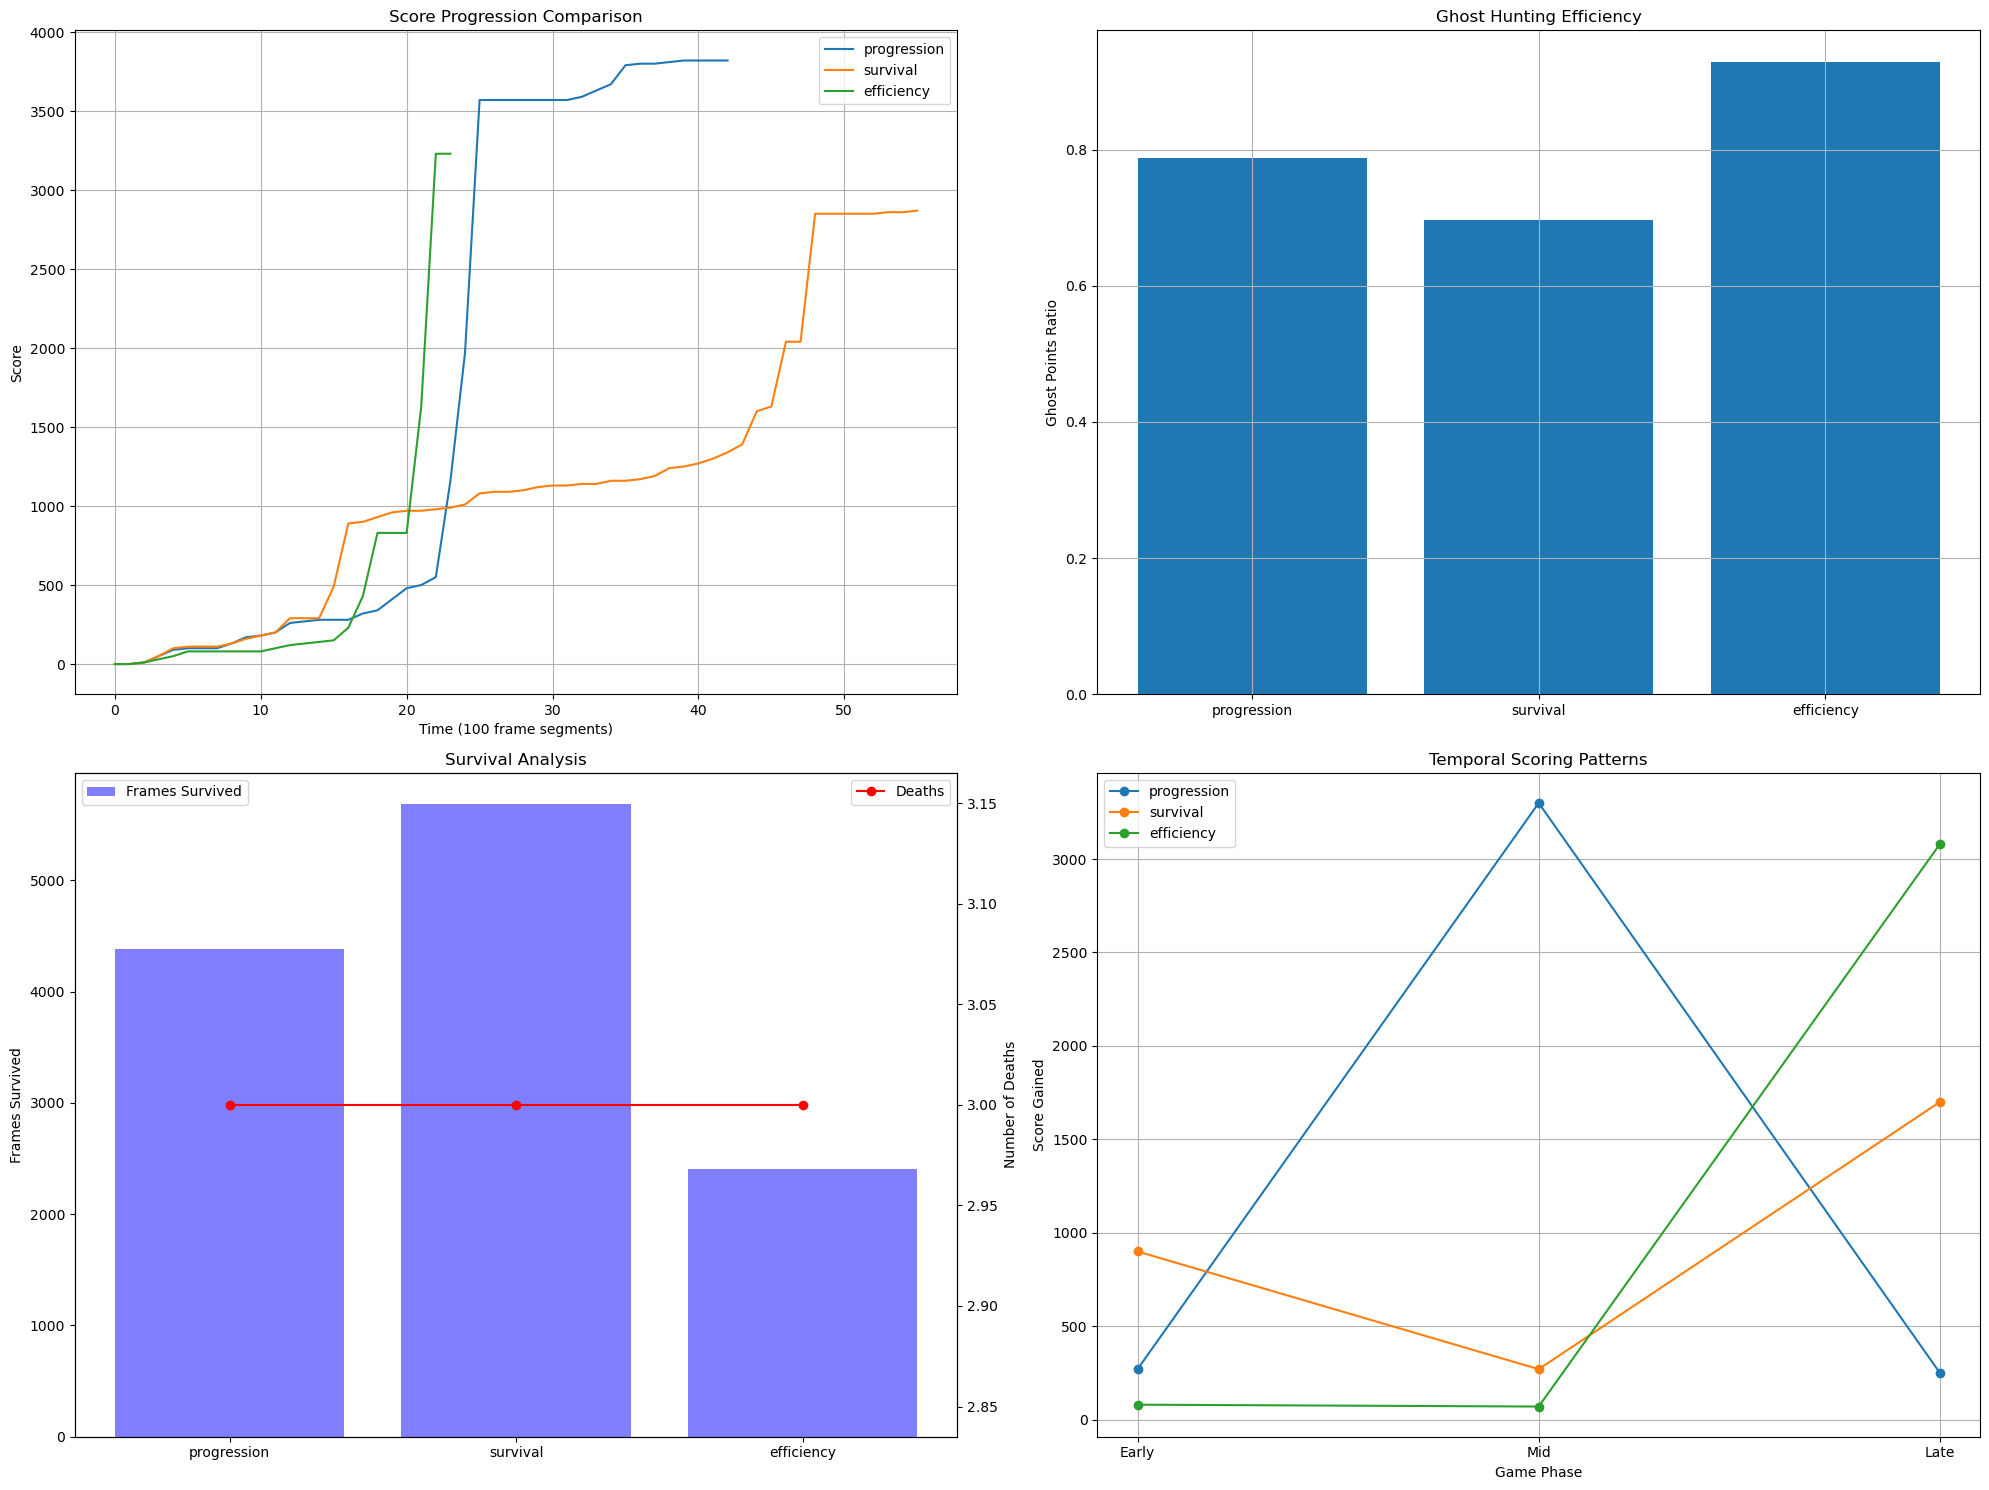

In [8]:
# Create visualisation of best agent performances
fig = plt.figure(figsize=(20, 15))

# 1. Score Progression Comparison
ax1 = fig.add_subplot(221)
for obj in best_agents.keys():
    metrics = best_agents[obj][3]
    ax1.plot(metrics['score_segments'], label=obj)
ax1.set_title('Score Progression Comparison')
ax1.set_xlabel('Time (100 frame segments)')
ax1.set_ylabel('Score')
ax1.legend()
ax1.grid(True)

# 2. Ghost Hunting Efficiency
ax2 = fig.add_subplot(222)
ghost_ratios = [analysis['ghost_hunting']['ghost_ratio'] for analysis in agent_analyses.values()]
plt.bar(best_agents.keys(), ghost_ratios)
ax2.set_title('Ghost Hunting Efficiency')
ax2.set_ylabel('Ghost Points Ratio')
ax2.grid(True)

# 3. Survival Analysis
ax3 = fig.add_subplot(223)
survival_times = [analysis['survival_stats']['frames_survived'] for analysis in agent_analyses.values()]
death_counts = [analysis['survival_stats']['deaths'] for analysis in agent_analyses.values()]
ax3_twin = ax3.twinx()
ax3.bar(best_agents.keys(), survival_times, color='blue', alpha=0.5, label='Frames Survived')
ax3_twin.plot(range(len(best_agents)), death_counts, 'r-o', label='Deaths')
ax3.set_title('Survival Analysis')
ax3.set_ylabel('Frames Survived')
ax3_twin.set_ylabel('Number of Deaths')
ax3.legend(loc='upper left')
ax3_twin.legend(loc='upper right')

# 4. Temporal Scoring Pattern
ax4 = fig.add_subplot(224)
for obj in best_agents.keys():
    temporal = agent_analyses[obj]['temporal_scoring']
    ax4.plot([temporal['early_game'], temporal['mid_game'], temporal['late_game']], 
             label=obj, marker='o')
ax4.set_title('Temporal Scoring Patterns')
ax4.set_xlabel('Game Phase')
ax4.set_xticks([0, 1, 2])
ax4.set_xticklabels(['Early', 'Mid', 'Late'])
ax4.set_ylabel('Score Gained')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

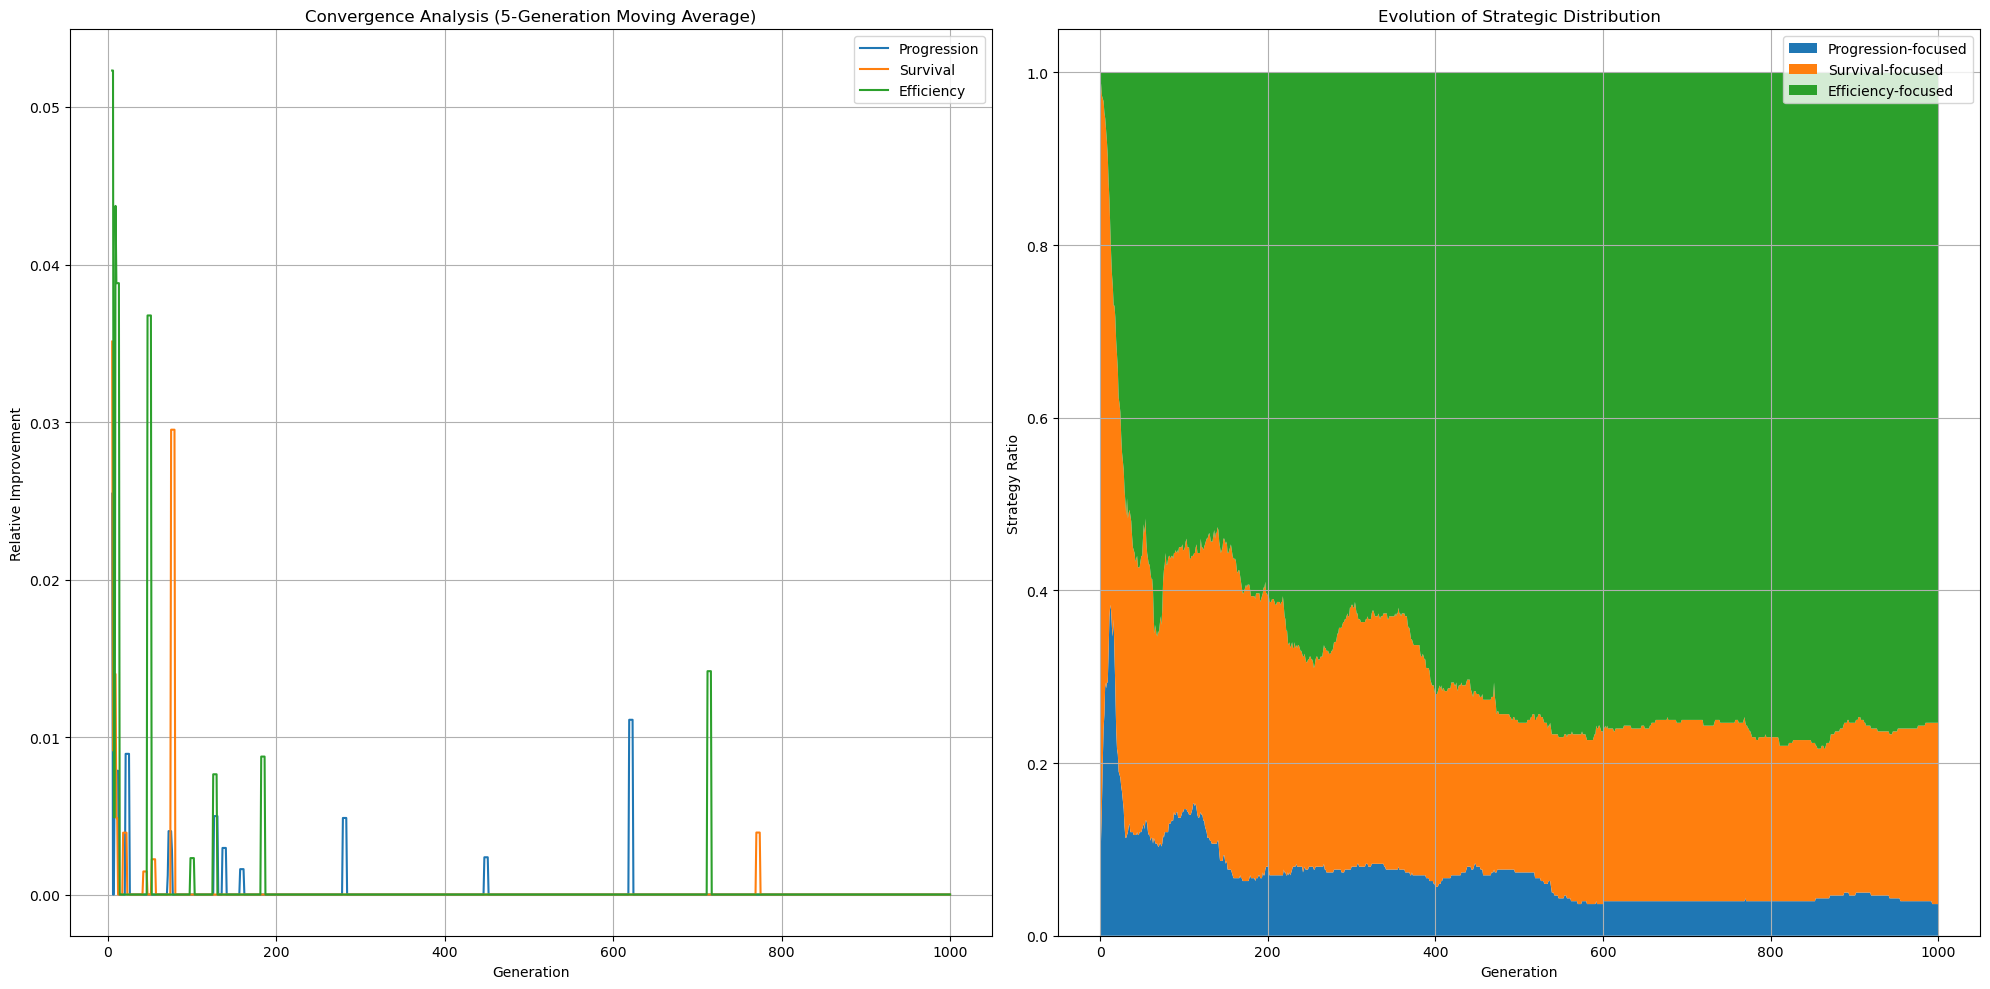


Final Performance Analysis:

Convergence Summary:
Final 10 generations average improvement:
Progression: 0.00%
Survival: 0.00%
Efficiency: 0.00%

Strategy Distribution in Final Generation:
Progression-focused: 3.7%
Survival-focused: 21.0%
Efficiency-focused: 75.3%


In [9]:
# Calculate convergence metrics
convergence_data = []
for gen in range(1, len(evolution_df)):
    prev_gen = evolution_df.iloc[gen-1]
    curr_gen = evolution_df.iloc[gen]
    
    improvement = {
        'generation': gen,
        'progression_improvement': (curr_gen['progression_max'] - prev_gen['progression_max']) / prev_gen['progression_max'],
        'survival_improvement': (curr_gen['survival_max'] - prev_gen['survival_max']) / prev_gen['survival_max'],
        'efficiency_improvement': (curr_gen['efficiency_max'] - prev_gen['efficiency_max']) / prev_gen['efficiency_max']
    }
    convergence_data.append(improvement)

convergence_df = pd.DataFrame(convergence_data)

# Visualise convergence and strategy evolution
fig = plt.figure(figsize=(20, 10))

# 1. Convergence Analysis
ax1 = fig.add_subplot(121)
ax1.plot(convergence_df['generation'], convergence_df['progression_improvement'].rolling(5).mean(), 
         label='Progression')
ax1.plot(convergence_df['generation'], convergence_df['survival_improvement'].rolling(5).mean(), 
         label='Survival')
ax1.plot(convergence_df['generation'], convergence_df['efficiency_improvement'].rolling(5).mean(), 
         label='Efficiency')
ax1.set_title('Convergence Analysis (5-Generation Moving Average)')
ax1.set_xlabel('Generation')
ax1.set_ylabel('Relative Improvement')
ax1.legend()
ax1.grid(True)

# 2. Strategy Distribution
ax2 = fig.add_subplot(122)
strategy_ratios = []
for gen in generation_history:
    obj_values = np.array(gen['objective_values'])
    dominant_strategy = np.argmax(obj_values, axis=1)
    ratios = [np.mean(dominant_strategy == i) for i in range(3)]
    strategy_ratios.append(ratios)

strategy_ratios = np.array(strategy_ratios)
ax2.stackplot(range(len(strategy_ratios)), 
              strategy_ratios.T, 
              labels=['Progression-focused', 'Survival-focused', 'Efficiency-focused'])
ax2.set_title('Evolution of Strategic Distribution')
ax2.set_xlabel('Generation')
ax2.set_ylabel('Strategy Ratio')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print final analysis
print("\nFinal Performance Analysis:")
print("\nConvergence Summary:")
final_improvements = convergence_df.iloc[-10:].mean()
print(f"Final 10 generations average improvement:")
print(f"Progression: {final_improvements['progression_improvement']*100:.2f}%")
print(f"Survival: {final_improvements['survival_improvement']*100:.2f}%")
print(f"Efficiency: {final_improvements['efficiency_improvement']*100:.2f}%")

print("\nStrategy Distribution in Final Generation:")
final_ratios = strategy_ratios[-1]
print(f"Progression-focused: {final_ratios[0]*100:.1f}%")
print(f"Survival-focused: {final_ratios[1]*100:.1f}%")
print(f"Efficiency-focused: {final_ratios[2]*100:.1f}%")

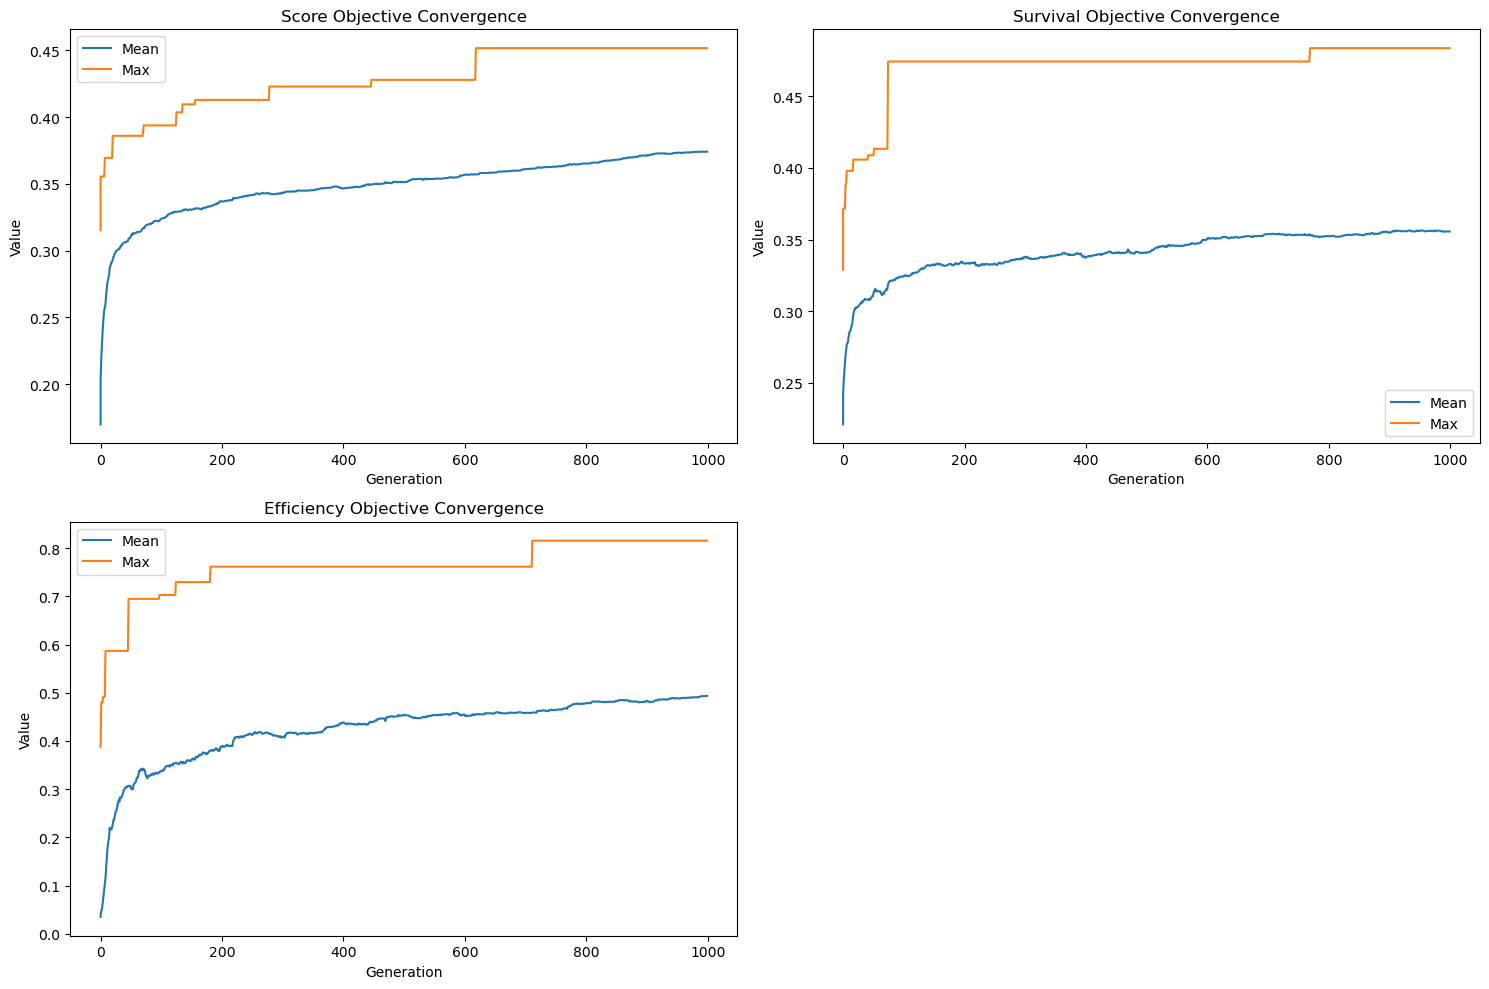

In [10]:
# Convergence Analysis
def analyse_convergence(generation_history):
    metrics = []
    
    for gen in generation_history:
        objectives = np.array([list(obj) for obj in gen['objective_values']])
        stats = gen['objective_stats']
        
        metrics.append({
            'generation': gen['generation'],
            'mean_score': stats['mean'][0],
            'mean_survival': stats['mean'][1],
            'mean_efficiency': stats['mean'][2],
            'max_score': stats['max'][0],
            'max_survival': stats['max'][1],
            'max_efficiency': stats['max'][2]
        })
    
    return pd.DataFrame(metrics)

convergence_df = analyse_convergence(results['generation_history'])

# Plot convergence metrics
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(convergence_df['generation'], convergence_df['mean_score'], label='Mean')
plt.plot(convergence_df['generation'], convergence_df['max_score'], label='Max')
plt.title('Score Objective Convergence')
plt.xlabel('Generation')
plt.ylabel('Value')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(convergence_df['generation'], convergence_df['mean_survival'], label='Mean')
plt.plot(convergence_df['generation'], convergence_df['max_survival'], label='Max')
plt.title('Survival Objective Convergence')
plt.xlabel('Generation')
plt.ylabel('Value')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(convergence_df['generation'], convergence_df['mean_efficiency'], label='Mean')
plt.plot(convergence_df['generation'], convergence_df['max_efficiency'], label='Max')
plt.title('Efficiency Objective Convergence')
plt.xlabel('Generation')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
# Function to visualise/playback agents using exact conditions from the simulation
def visualise_specialist_agent(action_sequence, seed, specialist_type="", n_episodes=1):
    """
    Visualise gameplay for a specialist agent
    
    Parameters:
    action_sequence: List of actions from the specialist agent
    seed: Seed used for reproducibility
    specialist_type: Indicating the type of specialist ('Progression', 'Survival', 'Efficiency')
    n_episodes: Number of episodes to run
    """
    base_env = gym.make("ALE/MsPacman-v5", render_mode="rgb_array")
    env = RecordEpisodeStatistics(base_env)
    
    # Initialise statistics tracking
    specific_keys = ['lives', 'episode_frame_number', 'frame_number']
    episode_stats = []
    
    for episode in range(n_episodes):
        observation, info = env.reset(seed=seed)
        env.action_space.seed(seed)
        total_reward = 0
        steps = 0
        terminated = False
        truncated = False
        episode_info = {key: [] for key in specific_keys}
        
        ghost_points = 0
        pellet_points = 0
        start_frame=0
        frame = 0
        
        while not (terminated or truncated):
            # Clear previous frame
            clear_output(wait=True)
            
            # Get action from specialist's action sequence
            action_idx = action_sequence[steps % len(action_sequence)] % len(LIMITED_ACTIONS)
            action = LIMITED_ACTIONS[action_idx]
            
            observation, reward, terminated, truncated, info = env.step(action)
            
            for key in specific_keys:
                if key in info:
                    episode_info[key].append(info[key])
                    
            if frame >= start_frame:
                total_reward += reward
                if reward >= GHOST_SCORE:
                    ghost_points += reward
                elif reward > 0:
                    pellet_points += reward
            
            frame += 1
            
            plt.figure(figsize=(8, 8))
            plt.imshow(observation)
            plt.axis('off')
            current_lives = info.get('lives', 'N/A')
            plt.title(f'{specialist_type} Specialist - Step {steps}\nScore: {total_reward} - Lives: {current_lives}')
            plt.show()
            
#             total_reward += reward
            steps += 1
        
        episode_stats.append({
            'episode': episode + 1,
            'total_reward': total_reward,
            'steps': steps,
            'time': env.time_queue[-1] if len(env.time_queue) > 0 else None,
            'return': env.return_queue[-1] if len(env.return_queue) > 0 else None,
            'ghost_points': ghost_points,
            'pellet_points': pellet_points,
#             'frames': length,
            'length': env.length_queue[-1] if len(env.length_queue) > 0 else None,
            **{key: episode_info[key] for key in specific_keys}
        })
        
        print(f"\n{specialist_type} Specialist Episode {episode + 1} Statistics:")
        print(f"Score: {total_reward}")
        print(f"Steps: {steps}")
        print(f"Final Lives: {episode_info['lives'][-1] if episode_info['lives'] else 'N/A'}")
        print(f"Total Frames: {episode_info['frame_number'][-1] if episode_info['frame_number'] else 'N/A'}")
        print(f"Ghost Points: {ghost_points}")
        print(f"Pellet Points: {pellet_points}")
        print(f"Seed: {seed}")
    
    env.close()
    return pd.DataFrame(episode_stats)

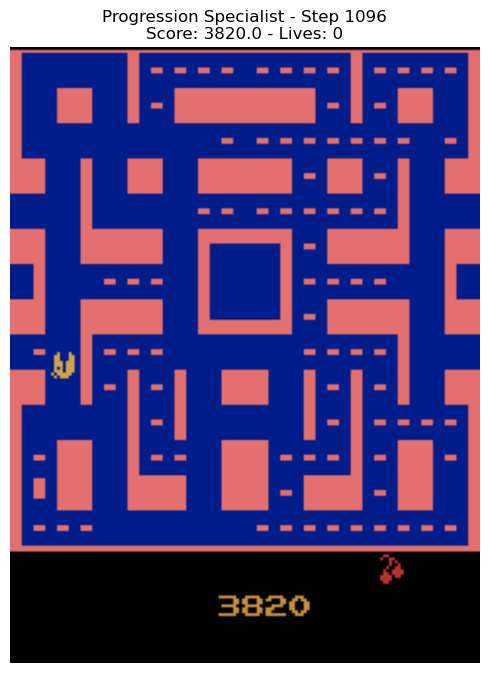


Progression Specialist Episode 1 Statistics:
Score: 3820.0
Steps: 1097
Final Lives: 0
Total Frames: 4385
Ghost Points: 3010.0
Pellet Points: 810.0
Seed: 511994
Progression Specialist Analysis:
------------------------------
Playstyle: Hunter
Total Score: 3820.0
Episode Duration: 4385 frames
Ghost Points: 3010.0 (78.8% of total)
Lives Lost: 3
Scoring Actions: 72

Fitness Values:
  Progression: 0.452
  Survival: 0.389
  Efficiency: 0.527

Detailed Playstyle Analysis:
Temporal Analysis:
  Early Game Activity: 0.019
  Mid Game Activity: 0.019
  Late Game Activity: 0.011
  Strategy Shifts: 0


In [12]:
# Analyse Progression Specialist
progression_data = best_agents['progression']
action_sequence = progression_data[0]
seed = progression_data[1]
fitness_values = progression_data[2]
metrics = progression_data[3]
playstyle_analysis = progression_data[4]  # Access existing playstyle analysis

print("Visualising Progression Specialist Gameplay:")
progression_stats = visualise_specialist_agent(
    progression_data[0],  # action sequence
    progression_data[1],  # seed
    "Progression",
    n_episodes=1
)

print("Progression Specialist Analysis:")
print("-" * 30)
print(f"Playstyle: {playstyle_analysis['playstyle']}")
print(f"Total Score: {metrics['total_score']}")
print(f"Episode Duration: {metrics['frames_survived']} frames")
print(f"Ghost Points: {metrics['ghost_points']} ({(metrics['ghost_points']/metrics['total_score'])*100:.1f}% of total)")
print(f"Lives Lost: {metrics['deaths']}")
print(f"Scoring Actions: {metrics['scoring_actions']}")
print("\nFitness Values:")
print(f"  Progression: {fitness_values[0]:.3f}")
print(f"  Survival: {fitness_values[1]:.3f}")
print(f"  Efficiency: {fitness_values[2]:.3f}")

print("\nDetailed Playstyle Analysis:")
print(f"Temporal Analysis:")
print(f"  Early Game Activity: {playstyle_analysis['temporal_analysis']['early_game_activity']:.3f}")
print(f"  Mid Game Activity: {playstyle_analysis['temporal_analysis']['mid_game_activity']:.3f}")
print(f"  Late Game Activity: {playstyle_analysis['temporal_analysis']['late_game_activity']:.3f}")
print(f"  Strategy Shifts: {playstyle_analysis['temporal_analysis']['strategy_shifts']}")

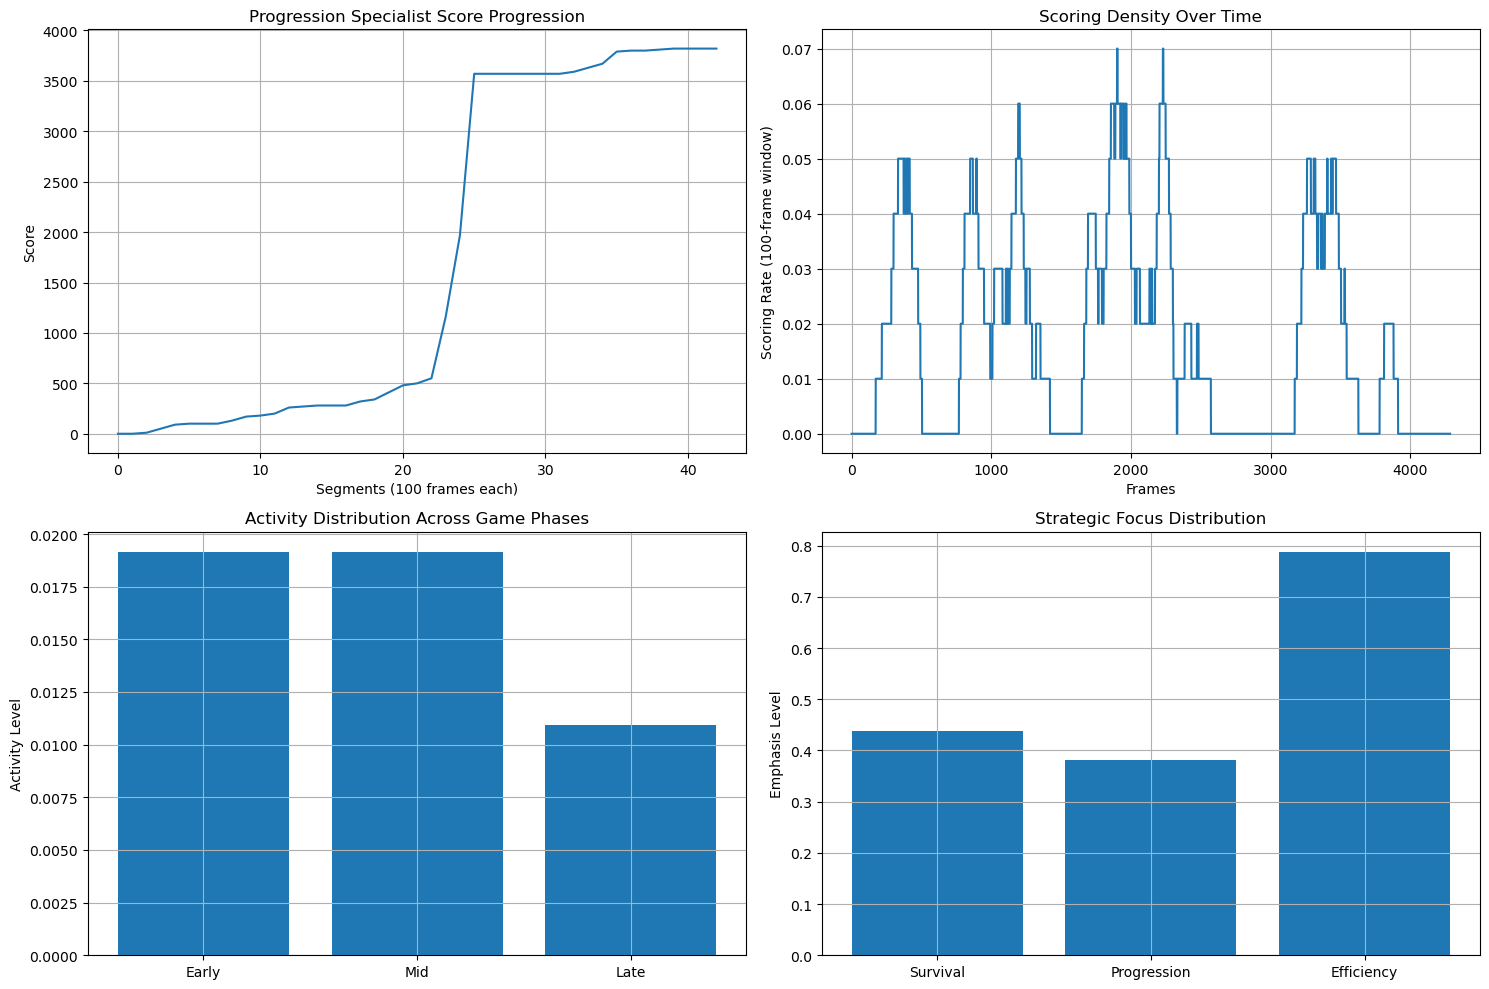


Strategic Pattern Analysis:
Early Game (0-1461 frames): 280.0 points
Mid Game (1461-2922 frames): 3290.0 points
Late Game (2922+ frames): 250.0 points


In [13]:
# Visualise Progression Specialist Performance
fig = plt.figure(figsize=(15, 10))

# Score progression subplot
ax1 = plt.subplot(2, 2, 1)
plt.plot(metrics['score_segments'])
plt.title("Progression Specialist Score Progression")
plt.xlabel("Segments (100 frames each)")
plt.ylabel("Score")
plt.grid(True)

# Scoring rate subplot
ax2 = plt.subplot(2, 2, 2)
score_changes = np.zeros(metrics['frames_survived'])
for frame in metrics['score_change_frames']:
    score_changes[frame] = 1
score_density = np.convolve(score_changes, np.ones(100)/100, mode='valid')
plt.plot(score_density)
plt.title("Scoring Density Over Time")
plt.xlabel("Frames")
plt.ylabel("Scoring Rate (100-frame window)")
plt.grid(True)

# Activity distribution subplot
ax3 = plt.subplot(2, 2, 3)
activities = [playstyle_analysis['temporal_analysis']['early_game_activity'],
             playstyle_analysis['temporal_analysis']['mid_game_activity'],
             playstyle_analysis['temporal_analysis']['late_game_activity']]
plt.bar(['Early', 'Mid', 'Late'], activities)
plt.title("Activity Distribution Across Game Phases")
plt.ylabel("Activity Level")
plt.grid(True)

# Strategic focus subplot
ax4 = plt.subplot(2, 2, 4)
focus_values = [playstyle_analysis['strategic_focus']['survival_emphasis'],
                playstyle_analysis['strategic_focus']['progression_emphasis'],
                playstyle_analysis['strategic_focus']['efficiency_emphasis']]
plt.bar(['Survival', 'Progression', 'Efficiency'], focus_values)
plt.title("Strategic Focus Distribution")
plt.ylabel("Emphasis Level")
plt.grid(True)

plt.tight_layout()
plt.show()

# Strategic Pattern Analysis
early_frames = metrics['frames_survived'] // 3
mid_frames = 2 * early_frames
early_score = metrics['score_segments'][min(len(metrics['score_segments'])-1, early_frames//100)]
mid_score = metrics['score_segments'][min(len(metrics['score_segments'])-1, mid_frames//100)]
final_score = metrics['total_score']

print("\nStrategic Pattern Analysis:")
print(f"Early Game (0-{early_frames} frames): {early_score} points")
print(f"Mid Game ({early_frames}-{mid_frames} frames): {mid_score-early_score} points")
print(f"Late Game ({mid_frames}+ frames): {final_score-mid_score} points")

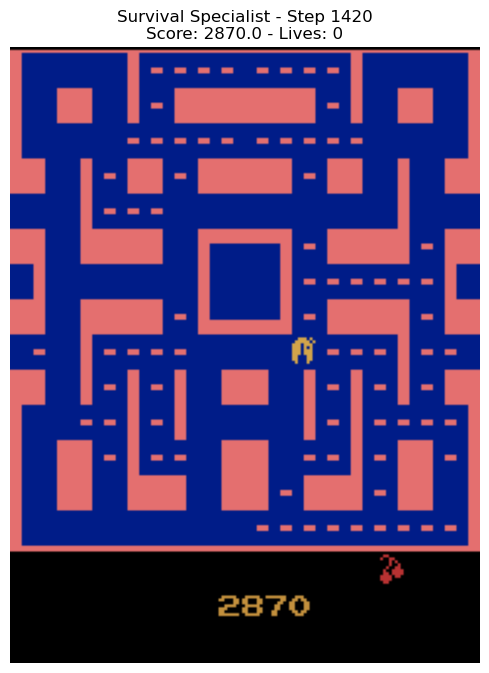


Survival Specialist Episode 1 Statistics:
Score: 2870.0
Steps: 1421
Final Lives: 0
Total Frames: 5681
Ghost Points: 2000.0
Pellet Points: 870.0
Seed: 171140
Survival Specialist Analysis:
------------------------------
Playstyle: Hunter
Total Score: 2870.0
Episode Duration: 5681 frames
Ghost Points: 2000.0 (69.7% of total)
Lives Lost: 3
Scoring Actions: 80

Fitness Values:
  Progression: 0.432
  Survival: 0.484
  Efficiency: 0.438

Detailed Playstyle Analysis:
Temporal Analysis:
  Early Game Activity: 0.016
  Mid Game Activity: 0.011
  Late Game Activity: 0.015
  Strategy Shifts: 0


In [14]:
# Analyse Survival Specialist
survival_data = best_agents['survival']
action_sequence = survival_data[0]
seed = survival_data[1]
fitness_values = survival_data[2]
metrics = survival_data[3]
playstyle_analysis = survival_data[4]

print("Visualising Survival Specialist Gameplay:")
survival_stats = visualise_specialist_agent(
    survival_data[0],  # action sequence
    survival_data[1],  # seed
    "Survival",
    n_episodes=1
)

print("Survival Specialist Analysis:")
print("-" * 30)
print(f"Playstyle: {playstyle_analysis['playstyle']}")
print(f"Total Score: {metrics['total_score']}")
print(f"Episode Duration: {metrics['frames_survived']} frames")
print(f"Ghost Points: {metrics['ghost_points']} ({(metrics['ghost_points']/metrics['total_score'])*100:.1f}% of total)")
print(f"Lives Lost: {metrics['deaths']}")
print(f"Scoring Actions: {metrics['scoring_actions']}")
print("\nFitness Values:")
print(f"  Progression: {fitness_values[0]:.3f}")
print(f"  Survival: {fitness_values[1]:.3f}")
print(f"  Efficiency: {fitness_values[2]:.3f}")

print("\nDetailed Playstyle Analysis:")
print(f"Temporal Analysis:")
print(f"  Early Game Activity: {playstyle_analysis['temporal_analysis']['early_game_activity']:.3f}")
print(f"  Mid Game Activity: {playstyle_analysis['temporal_analysis']['mid_game_activity']:.3f}")
print(f"  Late Game Activity: {playstyle_analysis['temporal_analysis']['late_game_activity']:.3f}")
print(f"  Strategy Shifts: {playstyle_analysis['temporal_analysis']['strategy_shifts']}")

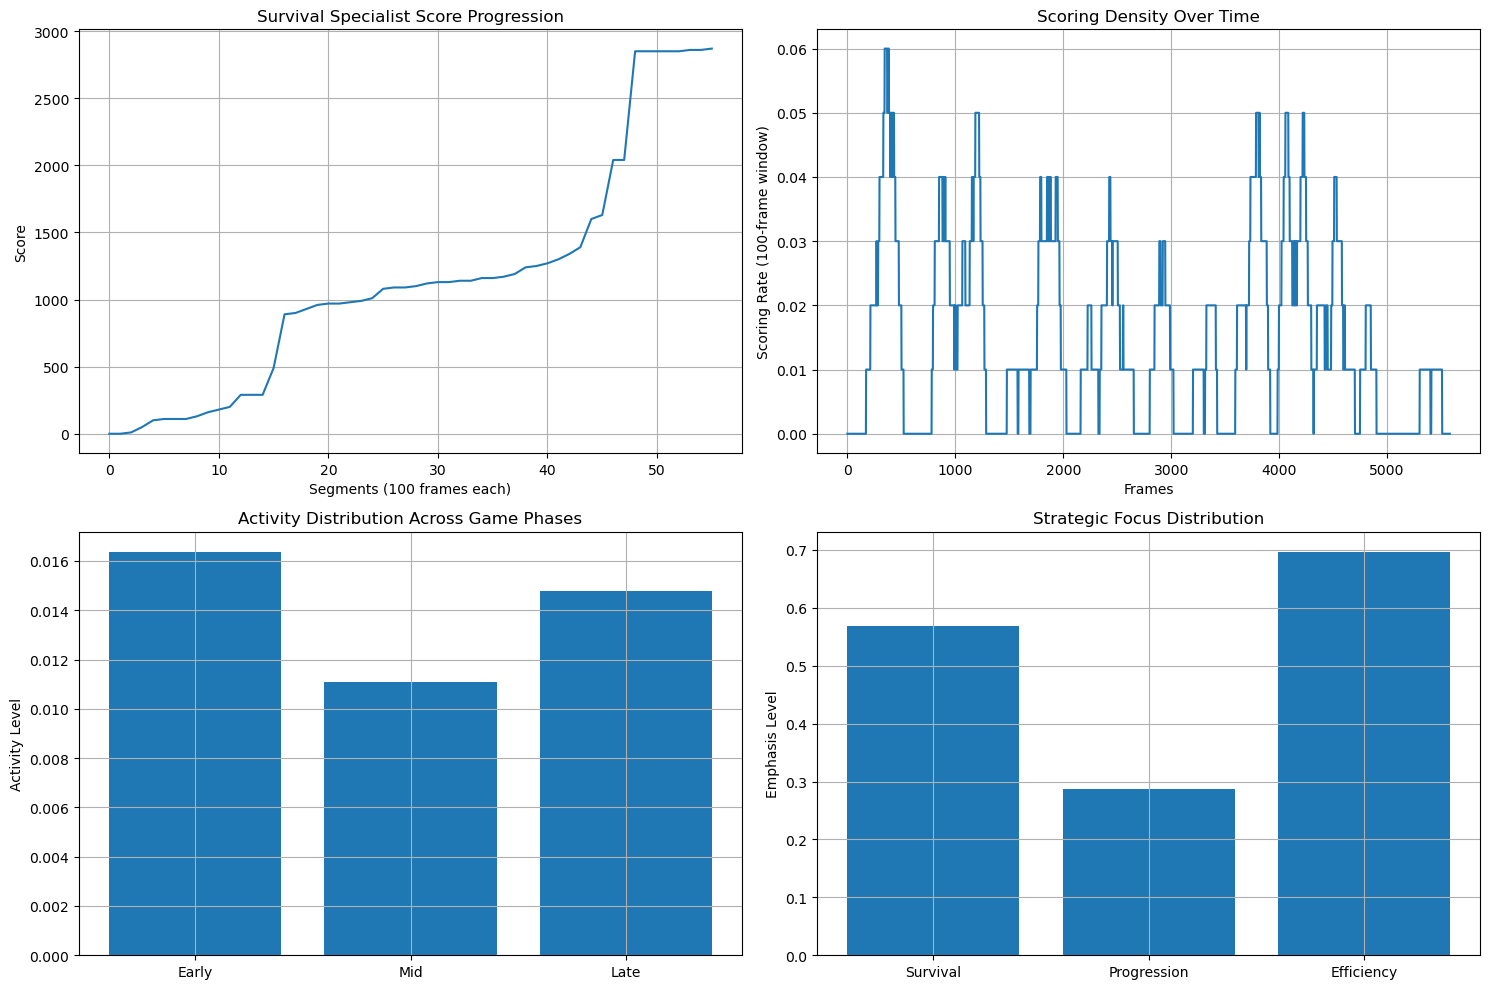


Strategic Pattern Analysis:
Early Game (0-1893 frames): 930.0 points
Mid Game (1893-3786 frames): 260.0 points
Late Game (3786+ frames): 1680.0 points


In [15]:
# Visualise Survival Specialist Performance
fig = plt.figure(figsize=(15, 10))

# Score progression subplot
ax1 = plt.subplot(2, 2, 1)
plt.plot(metrics['score_segments'])
plt.title("Survival Specialist Score Progression")
plt.xlabel("Segments (100 frames each)")
plt.ylabel("Score")
plt.grid(True)

# Scoring rate subplot
ax2 = plt.subplot(2, 2, 2)
score_changes = np.zeros(metrics['frames_survived'])
for frame in metrics['score_change_frames']:
    score_changes[frame] = 1
score_density = np.convolve(score_changes, np.ones(100)/100, mode='valid')
plt.plot(score_density)
plt.title("Scoring Density Over Time")
plt.xlabel("Frames")
plt.ylabel("Scoring Rate (100-frame window)")
plt.grid(True)

# Activity distribution subplot
ax3 = plt.subplot(2, 2, 3)
activities = [playstyle_analysis['temporal_analysis']['early_game_activity'],
             playstyle_analysis['temporal_analysis']['mid_game_activity'],
             playstyle_analysis['temporal_analysis']['late_game_activity']]
plt.bar(['Early', 'Mid', 'Late'], activities)
plt.title("Activity Distribution Across Game Phases")
plt.ylabel("Activity Level")
plt.grid(True)

# Strategic focus subplot
ax4 = plt.subplot(2, 2, 4)
focus_values = [playstyle_analysis['strategic_focus']['survival_emphasis'],
                playstyle_analysis['strategic_focus']['progression_emphasis'],
                playstyle_analysis['strategic_focus']['efficiency_emphasis']]
plt.bar(['Survival', 'Progression', 'Efficiency'], focus_values)
plt.title("Strategic Focus Distribution")
plt.ylabel("Emphasis Level")
plt.grid(True)

plt.tight_layout()
plt.show()

# Strategic Pattern Analysis
early_frames = metrics['frames_survived'] // 3
mid_frames = 2 * early_frames
early_score = metrics['score_segments'][min(len(metrics['score_segments'])-1, early_frames//100)]
mid_score = metrics['score_segments'][min(len(metrics['score_segments'])-1, mid_frames//100)]
final_score = metrics['total_score']

print("\nStrategic Pattern Analysis:")
print(f"Early Game (0-{early_frames} frames): {early_score} points")
print(f"Mid Game ({early_frames}-{mid_frames} frames): {mid_score-early_score} points")
print(f"Late Game ({mid_frames}+ frames): {final_score-mid_score} points")

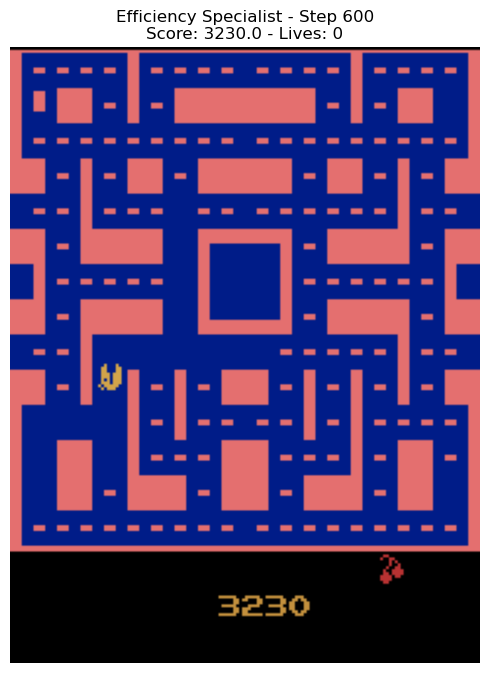


Efficiency Specialist Episode 1 Statistics:
Score: 3230.0
Steps: 601
Final Lives: 0
Total Frames: 2401
Ghost Points: 3000.0
Pellet Points: 230.0
Seed: 549576
Efficiency Specialist Analysis:
------------------------------
Playstyle: Hunter
Total Score: 3230.0
Episode Duration: 2401 frames
Ghost Points: 3000.0 (92.9% of total)
Lives Lost: 3
Scoring Actions: 23

Fitness Values:
  Progression: 0.336
  Survival: 0.252
  Efficiency: 0.815

Detailed Playstyle Analysis:
Temporal Analysis:
  Early Game Activity: 0.010
  Mid Game Activity: 0.009
  Late Game Activity: 0.010
  Strategy Shifts: 0


In [16]:
# Analyse Efficiency Specialist
efficiency_data = best_agents['efficiency']
action_sequence = efficiency_data[0]
seed = efficiency_data[1]
fitness_values = efficiency_data[2]
metrics = efficiency_data[3]
playstyle_analysis = efficiency_data[4]

print("Visualising Efficiency Specialist Gameplay:")
efficiency_stats = visualise_specialist_agent(
    efficiency_data[0],  # action sequence
    efficiency_data[1],  # seed
    "Efficiency",
    n_episodes=1
)

print("Efficiency Specialist Analysis:")
print("-" * 30)
print(f"Playstyle: {playstyle_analysis['playstyle']}")
print(f"Total Score: {metrics['total_score']}")
print(f"Episode Duration: {metrics['frames_survived']} frames")
print(f"Ghost Points: {metrics['ghost_points']} ({(metrics['ghost_points']/metrics['total_score'])*100:.1f}% of total)")
print(f"Lives Lost: {metrics['deaths']}")
print(f"Scoring Actions: {metrics['scoring_actions']}")
print("\nFitness Values:")
print(f"  Progression: {fitness_values[0]:.3f}")
print(f"  Survival: {fitness_values[1]:.3f}")
print(f"  Efficiency: {fitness_values[2]:.3f}")

print("\nDetailed Playstyle Analysis:")
print(f"Temporal Analysis:")
print(f"  Early Game Activity: {playstyle_analysis['temporal_analysis']['early_game_activity']:.3f}")
print(f"  Mid Game Activity: {playstyle_analysis['temporal_analysis']['mid_game_activity']:.3f}")
print(f"  Late Game Activity: {playstyle_analysis['temporal_analysis']['late_game_activity']:.3f}")
print(f"  Strategy Shifts: {playstyle_analysis['temporal_analysis']['strategy_shifts']}")

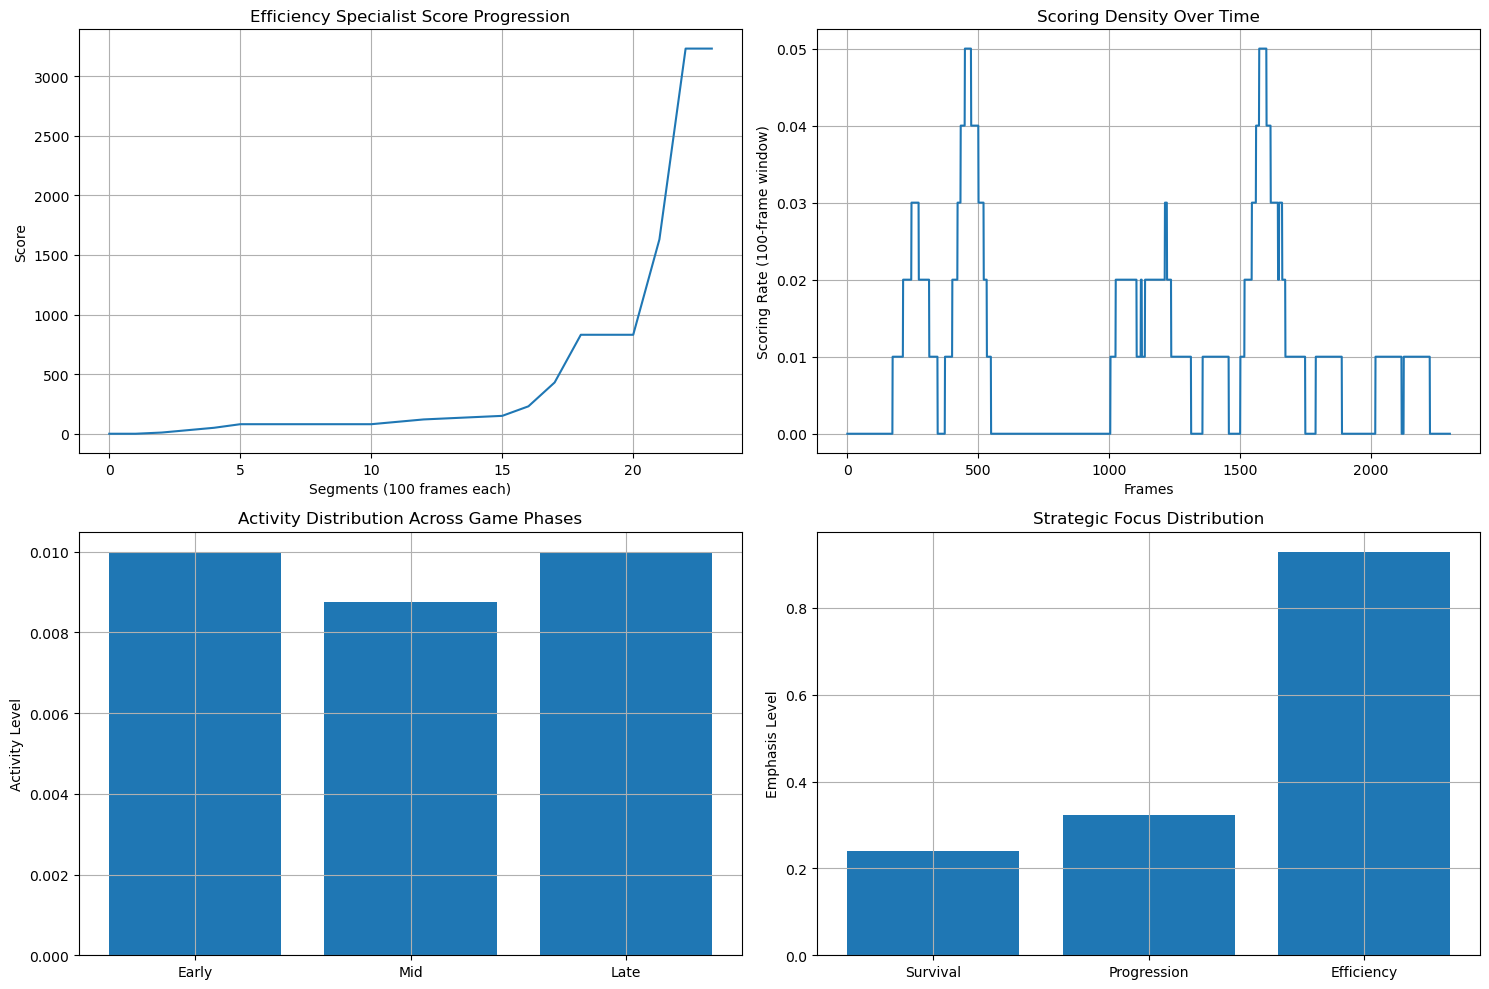


Strategic Pattern Analysis:
Early Game (0-800 frames): 80.0 points
Mid Game (800-1600 frames): 150.0 points
Late Game (1600+ frames): 3000.0 points


In [17]:
# Visualise Efficiency Specialist Performance
fig = plt.figure(figsize=(15, 10))

# Score progression subplot
ax1 = plt.subplot(2, 2, 1)
plt.plot(metrics['score_segments'])
plt.title("Efficiency Specialist Score Progression")
plt.xlabel("Segments (100 frames each)")
plt.ylabel("Score")
plt.grid(True)

# Scoring rate subplot
ax2 = plt.subplot(2, 2, 2)
score_changes = np.zeros(metrics['frames_survived'])
for frame in metrics['score_change_frames']:
    score_changes[frame] = 1
score_density = np.convolve(score_changes, np.ones(100)/100, mode='valid')
plt.plot(score_density)
plt.title("Scoring Density Over Time")
plt.xlabel("Frames")
plt.ylabel("Scoring Rate (100-frame window)")
plt.grid(True)

# Activity distribution subplot
ax3 = plt.subplot(2, 2, 3)
activities = [playstyle_analysis['temporal_analysis']['early_game_activity'],
             playstyle_analysis['temporal_analysis']['mid_game_activity'],
             playstyle_analysis['temporal_analysis']['late_game_activity']]
plt.bar(['Early', 'Mid', 'Late'], activities)
plt.title("Activity Distribution Across Game Phases")
plt.ylabel("Activity Level")
plt.grid(True)

# Strategic focus subplot
ax4 = plt.subplot(2, 2, 4)
focus_values = [playstyle_analysis['strategic_focus']['survival_emphasis'],
                playstyle_analysis['strategic_focus']['progression_emphasis'],
                playstyle_analysis['strategic_focus']['efficiency_emphasis']]
plt.bar(['Survival', 'Progression', 'Efficiency'], focus_values)
plt.title("Strategic Focus Distribution")
plt.ylabel("Emphasis Level")
plt.grid(True)

plt.tight_layout()
plt.show()

# Strategic Pattern Analysis
early_frames = metrics['frames_survived'] // 3
mid_frames = 2 * early_frames
early_score = metrics['score_segments'][min(len(metrics['score_segments'])-1, early_frames//100)]
mid_score = metrics['score_segments'][min(len(metrics['score_segments'])-1, mid_frames//100)]
final_score = metrics['total_score']

print("\nStrategic Pattern Analysis:")
print(f"Early Game (0-{early_frames} frames): {early_score} points")
print(f"Mid Game ({early_frames}-{mid_frames} frames): {mid_score-early_score} points")
print(f"Late Game ({mid_frames}+ frames): {final_score-mid_score} points")


Comparative Statistics:
          type  total_reward  steps  length
0  Progression        3820.0   1097    1097
1     Survival        2870.0   1421    1421
2   Efficiency        3230.0    601     601


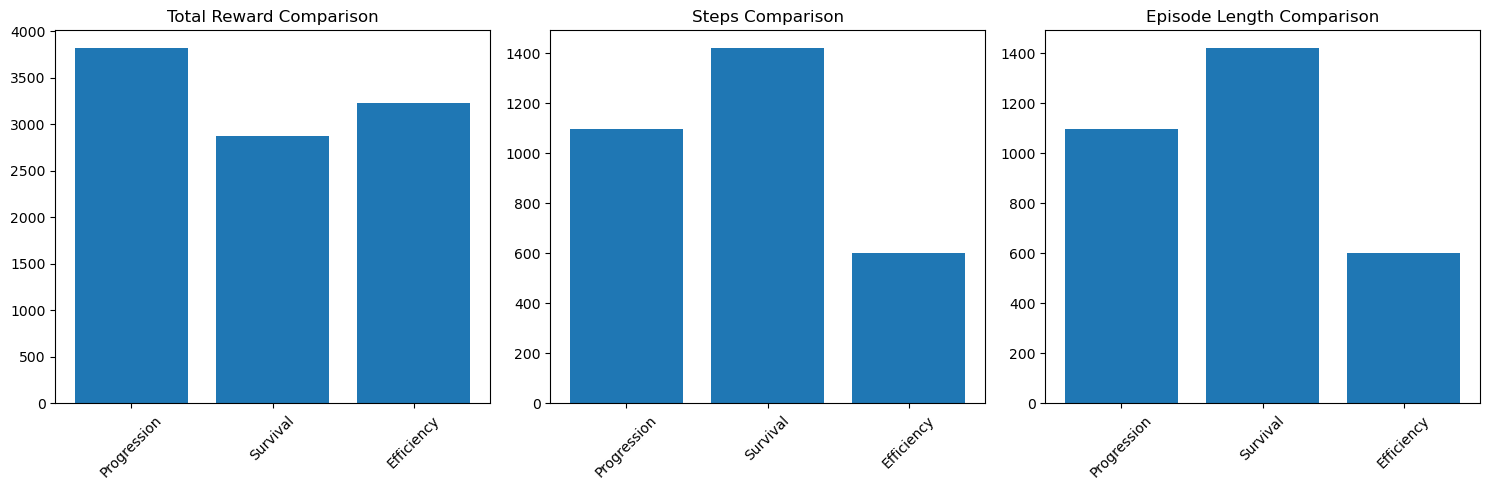

In [18]:
# Combine all statistics
all_stats = pd.concat([
    progression_stats.assign(type='Progression'),
    survival_stats.assign(type='Survival'),
    efficiency_stats.assign(type='Efficiency')
]).reset_index(drop=True)

print("\nComparative Statistics:")
print(all_stats[['type', 'total_reward', 'steps', 'length']].to_string())

# Create comparative visualisations
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(all_stats['type'], all_stats['total_reward'])
plt.title('Total Reward Comparison')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
plt.bar(all_stats['type'], all_stats['steps'])
plt.title('Steps Comparison')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
plt.bar(all_stats['type'], all_stats['length'])
plt.title('Episode Length Comparison')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [19]:
# Plot analysis functions

# Need to update action_names dictionary
action_names = {
    0: "UP",    # Was "NOOP"
    1: "RIGHT", # Was "UP"
    2: "DOWN",  # Was "RIGHT"
    3: "LEFT"   # Was "DOWN", "LEFT" was 4
}

def analyse_action_distribution(action_sequence):
    """Analyse the distribution of actions in the sequence"""
    # Convert actions to match LIMITED_ACTIONS indices
    actions = [action % len(LIMITED_ACTIONS) for action in action_sequence]
    
    # Count occurrences of each action
    action_counts = {action_names[i]: actions.count(i) for i in range(len(LIMITED_ACTIONS))}
    total_actions = len(action_sequence)
    action_percentages = {k: (v/total_actions)*100 for k, v in action_counts.items()}
    
    return action_counts, action_percentages

def plot_action_distribution(action_sequence, title="Action Distribution"):
    """Plot the distribution of actions"""
    action_counts, action_percentages = analyse_action_distribution(action_sequence)
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(action_counts.keys(), action_counts.values())
    plt.title(title)
    plt.xlabel("Action")
    plt.ylabel("Count")
    
    # Add percentage labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height/len(action_sequence)*100:.1f}%',
                ha='center', va='bottom')
    
    plt.grid(True, alpha=0.3)
    plt.show()

def analyse_life_losses(info_dict):
    """Analyse when lives were lost during gameplay"""
    lives = info_dict.get('lives', [])
    frames = info_dict.get('frame_number', [])
    
    life_loss_events = []
    for i in range(1, len(lives)):
        if lives[i] < lives[i-1]:
            life_loss_events.append({
                'frame': frames[i],
                'lives_remaining': lives[i]
            })
    
    return life_loss_events

def plot_life_timeline(info_dict, title="Life Loss Timeline"):
    """Plot the timeline of life losses"""
    lives = info_dict.get('lives', [])
    frames = info_dict.get('frame_number', [])
    
    plt.figure(figsize=(12, 6))
    plt.plot(frames, lives, 'b-', label='Lives')
    
    # Mark life loss events
    life_loss_events = analyse_life_losses(info_dict)
    if life_loss_events:
        loss_frames = [event['frame'] for event in life_loss_events]
        loss_lives = [event['lives_remaining'] for event in life_loss_events]
        plt.scatter(loss_frames, loss_lives, color='red', s=100, 
                   label='Life Lost', zorder=5)
        
        # Add annotations for life loss events
        for event in life_loss_events:
            plt.annotate(f'Frame: {event["frame"]}',
                        (event['frame'], event['lives_remaining']),
                        xytext=(10, 10), textcoords='offset points')
    
    plt.title(title)
    plt.xlabel("Frames")
    plt.ylabel("Lives Remaining")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

Progression Specialist Detailed Analysis
--------------------------------------------------

Action Distribution Analysis:
UP: 24.8%
RIGHT: 25.3%
DOWN: 25.1%
LEFT: 24.8%


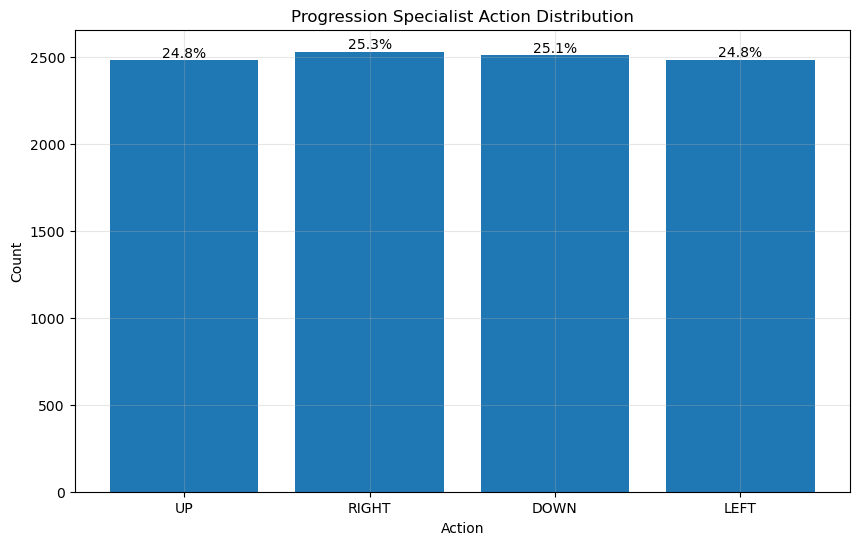


Life Loss Events:
Lost life at frame 700, 2 lives remaining
Lost life at frame 1508, 1 lives remaining
Lost life at frame 4385, 0 lives remaining


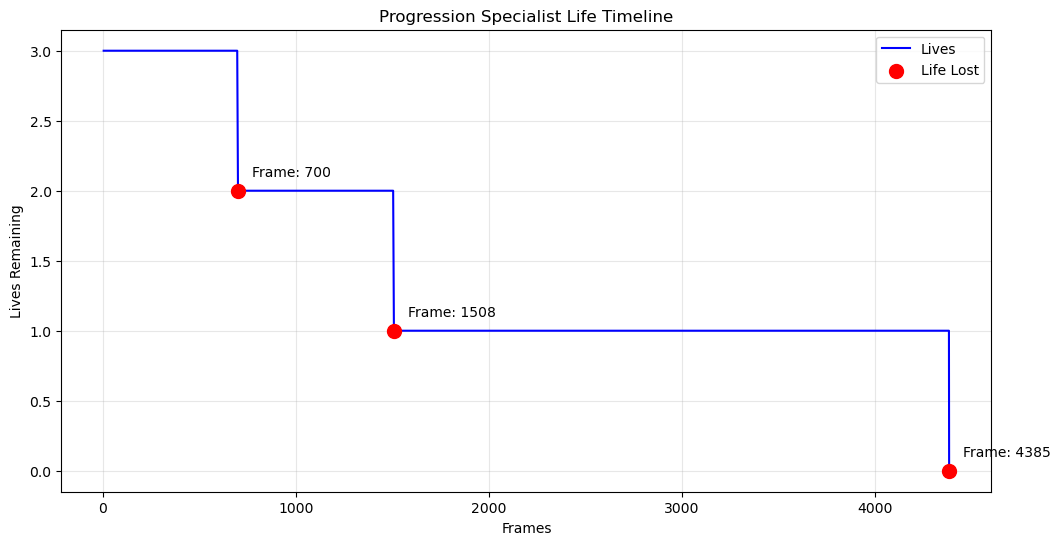

In [20]:
print("Progression Specialist Detailed Analysis")
print("-" * 50)

# Action distribution analysis
print("\nAction Distribution Analysis:")
action_counts, action_percentages = analyse_action_distribution(progression_data[0])
for action, percentage in action_percentages.items():
    print(f"{action}: {percentage:.1f}%")

# Visualise action distribution
plot_action_distribution(progression_data[0], "Progression Specialist Action Distribution")

# Life loss analysis
life_loss_events = analyse_life_losses(progression_stats.iloc[0])
print("\nLife Loss Events:")
for event in life_loss_events:
    print(f"Lost life at frame {event['frame']}, {event['lives_remaining']} lives remaining")

# Visualise life timeline
plot_life_timeline(progression_stats.iloc[0], "Progression Specialist Life Timeline")

Survival Specialist Detailed Analysis
--------------------------------------------------

Action Distribution Analysis:
UP: 24.8%
RIGHT: 24.8%
DOWN: 25.6%
LEFT: 24.8%


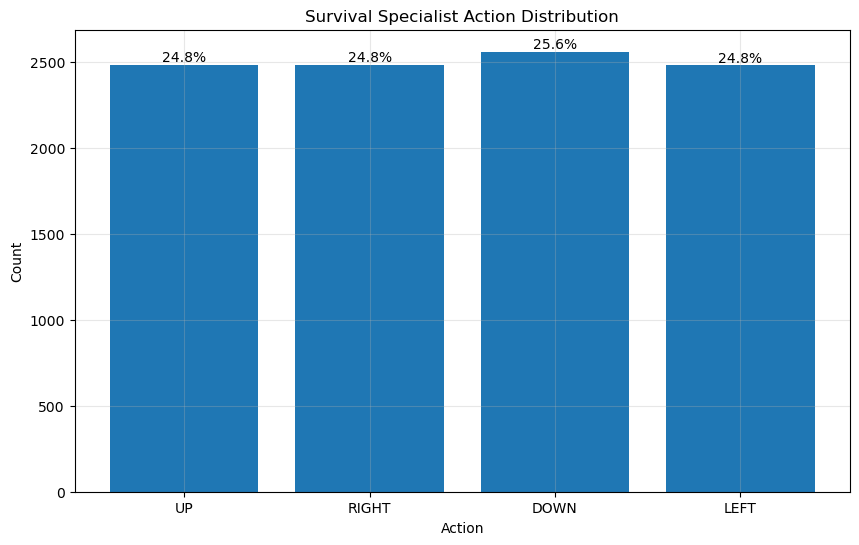


Life Loss Events:
Lost life at frame 700, 2 lives remaining
Lost life at frame 5164, 1 lives remaining
Lost life at frame 5681, 0 lives remaining


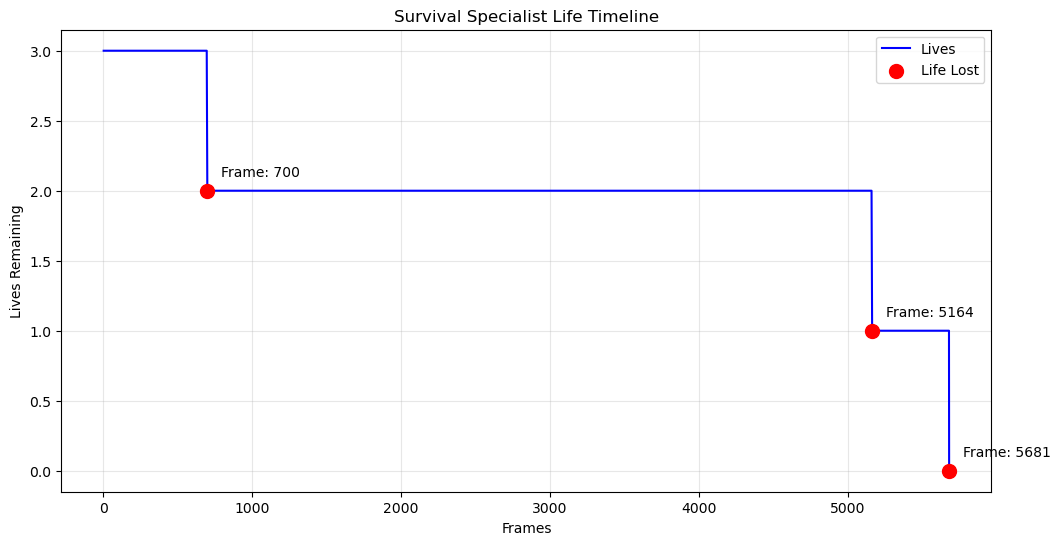

In [21]:
print("Survival Specialist Detailed Analysis")
print("-" * 50)

# Action distribution analysis
print("\nAction Distribution Analysis:")
action_counts, action_percentages = analyse_action_distribution(survival_data[0])
for action, percentage in action_percentages.items():
    print(f"{action}: {percentage:.1f}%")

# Visualise action distribution
plot_action_distribution(survival_data[0], "Survival Specialist Action Distribution")

# Life loss analysis
life_loss_events = analyse_life_losses(survival_stats.iloc[0])
print("\nLife Loss Events:")
for event in life_loss_events:
    print(f"Lost life at frame {event['frame']}, {event['lives_remaining']} lives remaining")

# Visualise life timeline
plot_life_timeline(survival_stats.iloc[0], "Survival Specialist Life Timeline")

Efficiency Specialist Detailed Analysis
--------------------------------------------------

Action Distribution Analysis:
UP: 25.5%
RIGHT: 25.0%
DOWN: 25.3%
LEFT: 24.2%


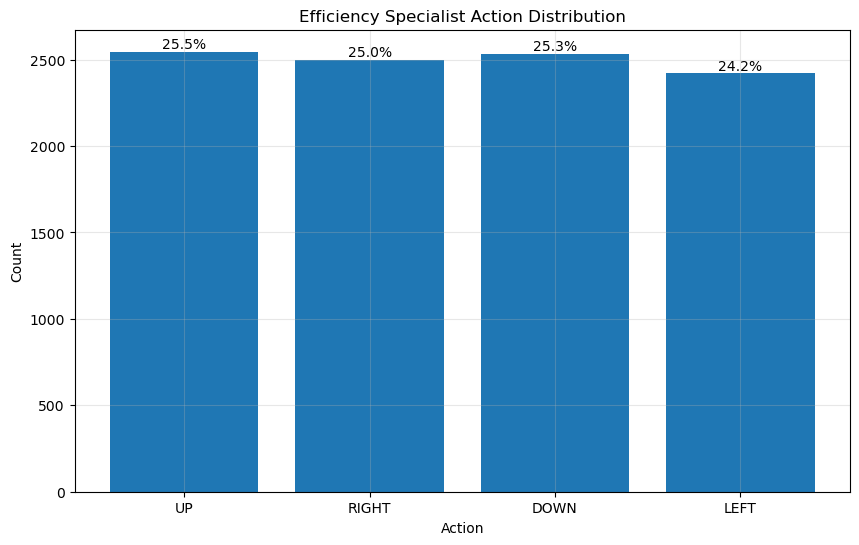


Life Loss Events:
Lost life at frame 628, 2 lives remaining
Lost life at frame 916, 1 lives remaining
Lost life at frame 2401, 0 lives remaining


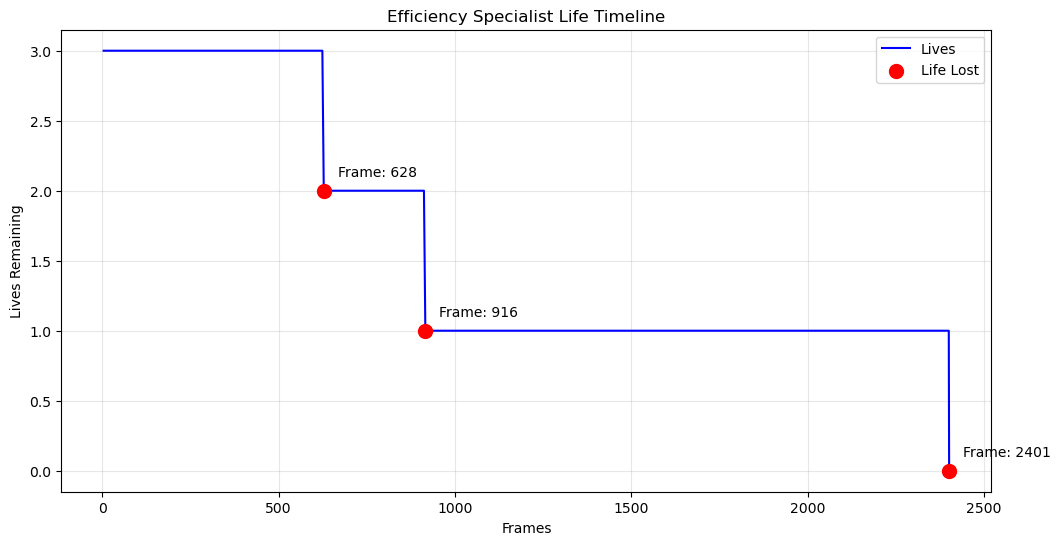

In [22]:
print("Efficiency Specialist Detailed Analysis")
print("-" * 50)

# Action distribution analysis
print("\nAction Distribution Analysis:")
action_counts, action_percentages = analyse_action_distribution(efficiency_data[0])
for action, percentage in action_percentages.items():
    print(f"{action}: {percentage:.1f}%")

# Visualise action distribution
plot_action_distribution(efficiency_data[0], "Efficiency Specialist Action Distribution")

# Life loss analysis
life_loss_events = analyse_life_losses(efficiency_stats.iloc[0])
print("\nLife Loss Events:")
for event in life_loss_events:
    print(f"Lost life at frame {event['frame']}, {event['lives_remaining']} lives remaining")

# Visualise life timeline
plot_life_timeline(efficiency_stats.iloc[0], "Efficiency Specialist Life Timeline")

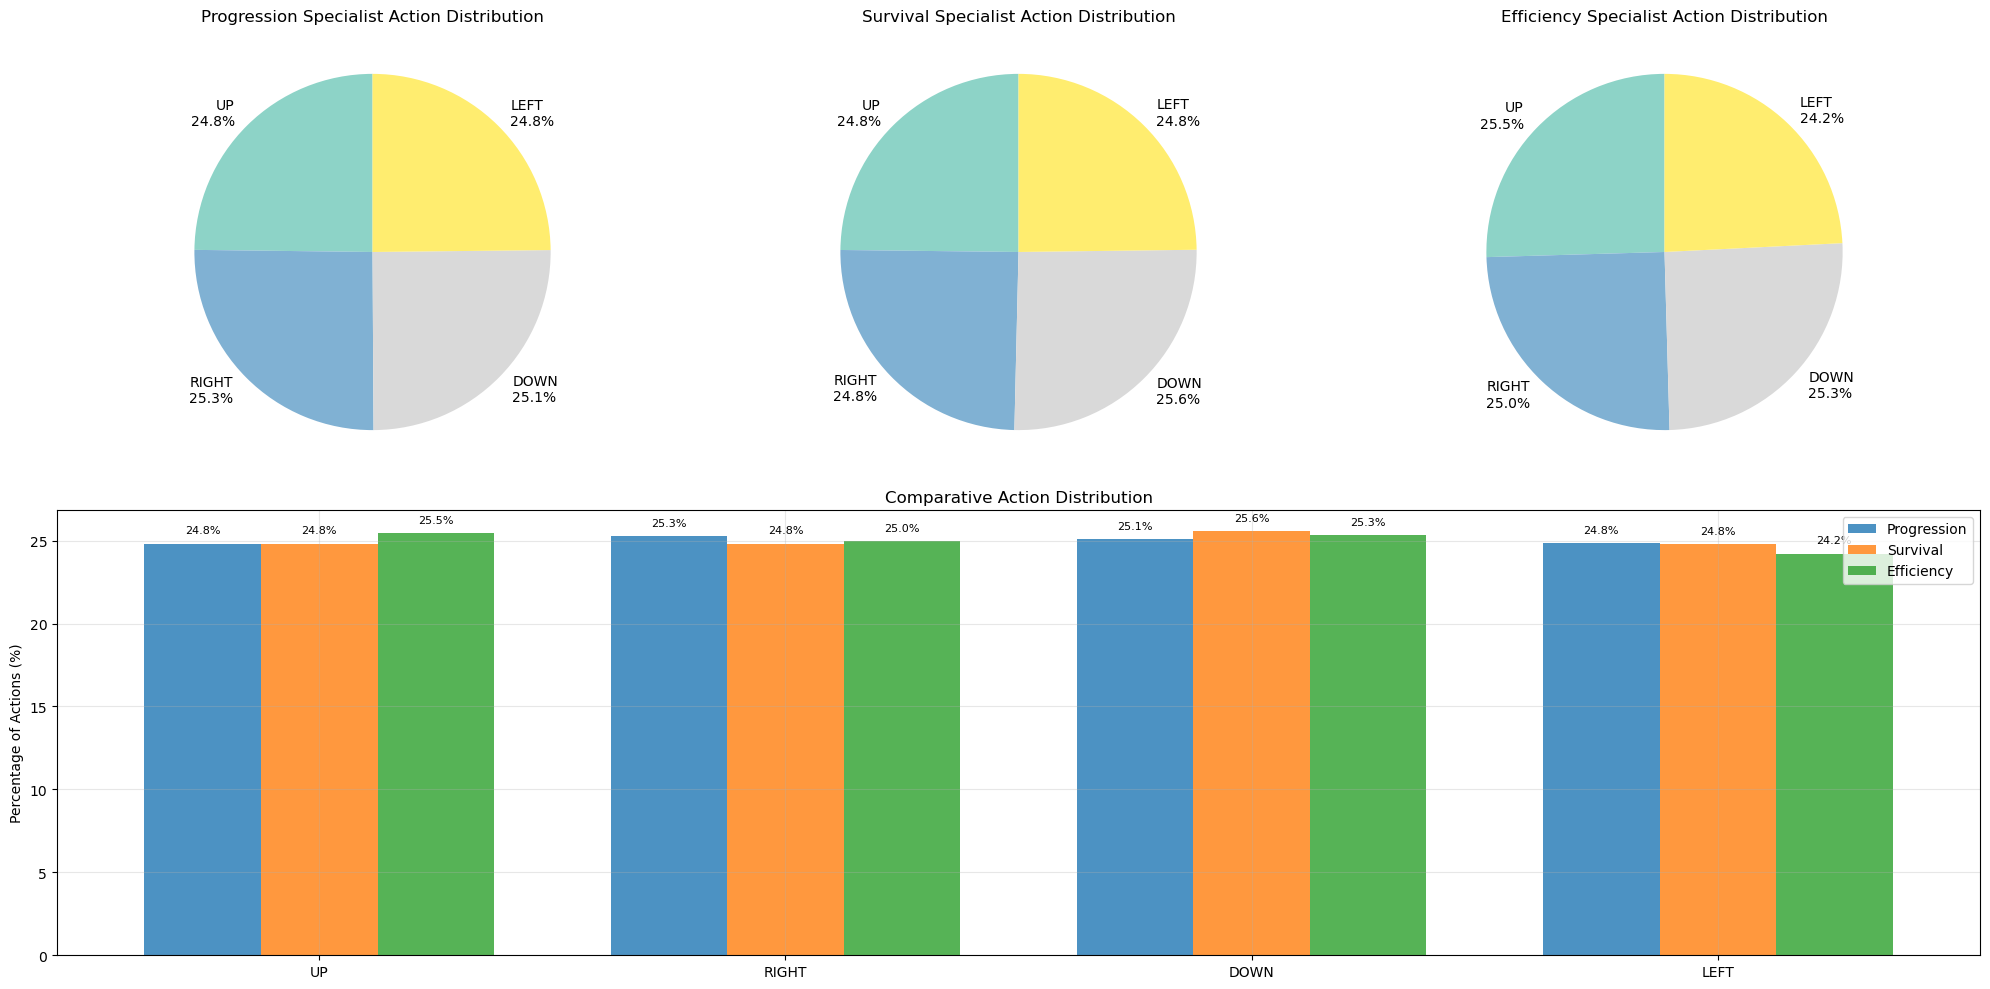


Detailed Action Distribution Comparison:
--------------------------------------------------

UP:
Progression: 24.8%
Survival: 24.8%
Efficiency: 25.5%

RIGHT:
Progression: 25.3%
Survival: 24.8%
Efficiency: 25.0%

DOWN:
Progression: 25.1%
Survival: 25.6%
Efficiency: 25.3%

LEFT:
Progression: 24.8%
Survival: 24.8%
Efficiency: 24.2%

Comparative Analysis:
--------------------------------------------------

Progression Specialist:
Most used actions:
  RIGHT: 25.3%
  DOWN: 25.1%
  LEFT: 24.8%

Survival Specialist:
Most used actions:
  DOWN: 25.6%
  UP: 24.8%
  RIGHT: 24.8%

Efficiency Specialist:
Most used actions:
  UP: 25.5%
  DOWN: 25.3%
  RIGHT: 25.0%


In [23]:
# Compare action distributions across specialists
# Create subplots for pie charts and comparative bar chart
fig = plt.figure(figsize=(20, 10))
gs = plt.GridSpec(2, 3)

specialists = ['Progression', 'Survival', 'Efficiency']
specialist_data = [progression_data[0], survival_data[0], efficiency_data[0]]
colors = plt.cm.Set3(np.linspace(0, 1, len(action_names)))

# Store percentages for comparative bar chart
all_percentages = []

# Create pie charts
for i, (specialist, data) in enumerate(zip(specialists, specialist_data)):
    plt.subplot(gs[0, i])
    action_counts, percentages = analyse_action_distribution(data)
    all_percentages.append(list(percentages.values()))
    
    # Create pie chart
    plt.pie(action_counts.values(), 
            labels=[f"{action}\n{pct:.1f}%" for action, pct in percentages.items()],
            colors=colors,
            autopct='',
            startangle=90)
    plt.title(f"{specialist} Specialist Action Distribution")

# Create comparative bar chart
ax_bar = plt.subplot(gs[1, :])
x = np.arange(len(action_names))
width = 0.25

for i, (specialist, percentages) in enumerate(zip(specialists, all_percentages)):
    ax_bar.bar(x + i*width, percentages, width, 
               label=specialist, alpha=0.8)

# Customise bar chart
ax_bar.set_ylabel('Percentage of Actions (%)')
ax_bar.set_title('Comparative Action Distribution')
ax_bar.set_xticks(x + width)
ax_bar.set_xticklabels(action_names.values())
ax_bar.legend()
ax_bar.grid(True, alpha=0.3)

# Add percentage labels on the bars
for i, percentages in enumerate(all_percentages):
    for j, v in enumerate(percentages):
        ax_bar.text(j + i*width, v + 0.5, f'{v:.1f}%', 
                   ha='center', va='bottom',
                   fontsize=8)

plt.tight_layout()
plt.show()

# Print detailed comparison
print("\nDetailed Action Distribution Comparison:")
print("-" * 50)
for action in action_names.values():
    print(f"\n{action}:")
    for specialist, percentages in zip(specialists, all_percentages):
        idx = list(action_names.values()).index(action)
        print(f"{specialist}: {percentages[idx]:.1f}%")
        
# Print summary statistics
print("\nComparative Analysis:")
print("-" * 50)
for specialist, data in zip(specialists, specialist_data):
    _, percentages = analyse_action_distribution(data)
    print(f"\n{specialist} Specialist:")
    print("Most used actions:")
    sorted_actions = sorted(percentages.items(), key=lambda x: x[1], reverse=True)
    for action, pct in sorted_actions[:3]:
        print(f"  {action}: {pct:.1f}%")

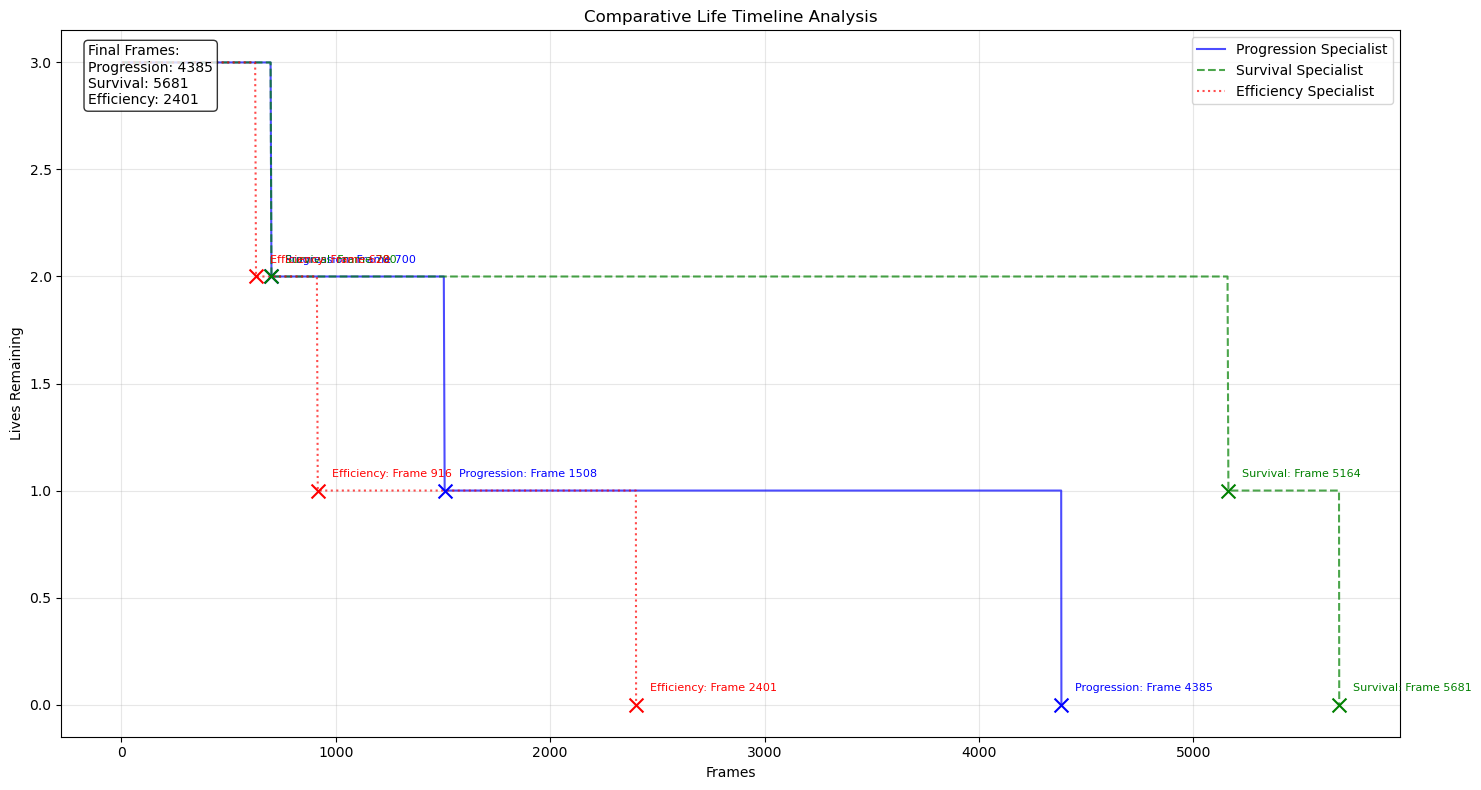

In [24]:
plt.figure(figsize=(15, 8))

# Plot each specialist's life timeline with different colours and styles
specialists_data = [
    (progression_stats.iloc[0], 'Progression', 'blue', '-'),
    (survival_stats.iloc[0], 'Survival', 'green', '--'),
    (efficiency_stats.iloc[0], 'Efficiency', 'red', ':')
]

for info_dict, name, color, style in specialists_data:
    lives = info_dict.get('lives', [])
    frames = info_dict.get('frame_number', [])
    
    # Plot life line
    plt.plot(frames, lives, color=color, linestyle=style, label=f'{name} Specialist', alpha=0.7)
    
    # Plot life loss events
    life_loss_events = analyse_life_losses(info_dict)
    if life_loss_events:
        loss_frames = [event['frame'] for event in life_loss_events]
        loss_lives = [event['lives_remaining'] for event in life_loss_events]
        plt.scatter(loss_frames, loss_lives, color=color, s=100, 
                   marker='x', zorder=5)
        
        # Add annotations for life loss events
        for event in life_loss_events:
            plt.annotate(f'{name}: Frame {event["frame"]}',
                        (event['frame'], event['lives_remaining']),
                        xytext=(10, 10), textcoords='offset points',
                        color=color, fontsize=8)

plt.title("Comparative Life Timeline Analysis")
plt.xlabel("Frames")
plt.ylabel("Lives Remaining")
plt.grid(True, alpha=0.3)
plt.legend()

# Add summary statistics in text box
textstr = '\n'.join([
    'Final Frames:',
    f'Progression: {progression_stats.iloc[0]["frame_number"][-1]}',
    f'Survival: {survival_stats.iloc[0]["frame_number"][-1]}',
    f'Efficiency: {efficiency_stats.iloc[0]["frame_number"][-1]}'
])

# Text box with summary stats
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

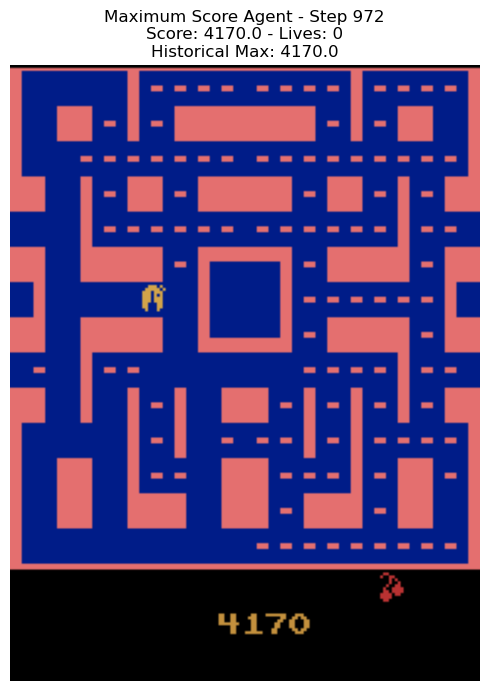


Maximum Score Agent Statistics:
------------------------------
Score: 4170.0
Historical Max Score: 4170.0
Generation Found: 867
Steps: 973
Final Lives: 0
Ghost Points: 3600.0 (86.3% of total)
Pellet Points: 570.0 (13.7% of total)
Lives Lost: 3
Scoring Actions: 55
Seed: 189375

Fitness Values:
  Progression: 0.421
  Survival: 0.344
  Efficiency: 0.621

Detailed Playstyle Analysis:
Playstyle: Hunter

Temporal Analysis:
  Early Game Activity: 0.017
  Mid Game Activity: 0.009
  Late Game Activity: 0.016
  Strategy Shifts: 0

Strategic Focus:
  Survival Emphasis: 0.389
  Progression Emphasis: 0.417
  Efficiency Emphasis: 0.863


In [25]:
# The agent that scored the maximum points regardless of objective

def visualise_max_score_agent(results, n_episodes=1):
    """
    Visualise and analyse the agent that achieved the maximum game score.
    """
    base_env = gym.make("ALE/MsPacman-v5", render_mode="rgb_array")
    env = RecordEpisodeStatistics(base_env)
    LIMITED_ACTIONS = [1, 2, 3, 4]
    GHOST_SCORE = 200
    
    # Get max score agent information directly from results
    max_score_agent = results['performance_metrics']['max_score_agent']
    max_score_individual = max_score_agent['individual']
    max_score_seed = max_score_agent['seed']
    max_score_metrics = max_score_agent['metrics']
    fitness_values = max_score_agent['fitness_values']
    playstyle_data = max_score_agent['playstyle']
    
    # Initialise statistics tracking
    specific_keys = ['lives', 'episode_frame_number', 'frame_number']
    episode_stats = []
    
    for episode in range(n_episodes):
        observation, info = env.reset(seed=max_score_seed)
        env.action_space.seed(max_score_seed)
        total_reward = 0
        ghost_points = 0
        pellet_points = 0
        steps = 0
        frame = 0
        
        terminated = False
        truncated = False
        episode_info = {key: [] for key in specific_keys}
        
        while not (terminated or truncated):
            clear_output(wait=True)
            
            action_idx = max_score_individual[steps % len(max_score_individual)] % len(LIMITED_ACTIONS)
            action = LIMITED_ACTIONS[action_idx]
            
            observation, reward, terminated, truncated, info = env.step(action)
            
            for key in specific_keys:
                if key in info:
                    episode_info[key].append(info[key])
            
            total_reward += reward
            if reward >= GHOST_SCORE:
                ghost_points += reward
            elif reward > 0:
                pellet_points += reward
            
            plt.figure(figsize=(8, 8))
            plt.imshow(observation)
            plt.axis('off')
            current_lives = info.get('lives', 'N/A')
            plt.title(f'Maximum Score Agent - Step {steps}\n'
                     f'Score: {total_reward} - Lives: {current_lives}\n'
                     f'Historical Max: {max_score_agent["total_score"]}')
            plt.show()
            
            steps += 1
            frame += 1
        
        # Record episode statistics
        episode_stats.append({
            'episode': episode + 1,
            'total_reward': total_reward,
            'steps': steps,
            'ghost_points': ghost_points,
            'pellet_points': pellet_points,
            'time': env.time_queue[-1] if len(env.time_queue) > 0 else None,
            'return': env.return_queue[-1] if len(env.return_queue) > 0 else None,
            'length': env.length_queue[-1] if len(env.length_queue) > 0 else None,
            **{key: episode_info[key] for key in specific_keys}
        })
        
        # Print comprehensive statistics
        print("\nMaximum Score Agent Statistics:")
        print("-" * 30)
        print(f"Score: {total_reward}")
        print(f"Historical Max Score: {max_score_agent['total_score']}")
        print(f"Generation Found: {max_score_agent['generation']}")
        print(f"Steps: {steps}")
        print(f"Final Lives: {episode_info['lives'][-1] if episode_info['lives'] else 'N/A'}")
        print(f"Ghost Points: {ghost_points} ({(ghost_points/max(1, total_reward))*100:.1f}% of total)")
        print(f"Pellet Points: {pellet_points} ({(pellet_points/max(1, total_reward))*100:.1f}% of total)")
        print(f"Lives Lost: {max_score_metrics.get('deaths', 'N/A')}")
        print(f"Scoring Actions: {max_score_metrics.get('scoring_actions', 'N/A')}")
        print(f"Seed: {max_score_seed}")
        
        print("\nFitness Values:")
        print(f"  Progression: {fitness_values[0]:.3f}")
        print(f"  Survival: {fitness_values[1]:.3f}")
        print(f"  Efficiency: {fitness_values[2]:.3f}")
        
        print("\nDetailed Playstyle Analysis:")
        print(f"Playstyle: {playstyle_data['playstyle']}")
        print(f"\nTemporal Analysis:")
        print(f"  Early Game Activity: {playstyle_data['temporal_analysis']['early_game_activity']:.3f}")
        print(f"  Mid Game Activity: {playstyle_data['temporal_analysis']['mid_game_activity']:.3f}")
        print(f"  Late Game Activity: {playstyle_data['temporal_analysis']['late_game_activity']:.3f}")
        print(f"  Strategy Shifts: {playstyle_data['temporal_analysis']['strategy_shifts']}")
        
        print("\nStrategic Focus:")
        print(f"  Survival Emphasis: {playstyle_data['strategic_focus']['survival_emphasis']:.3f}")
        print(f"  Progression Emphasis: {playstyle_data['strategic_focus']['progression_emphasis']:.3f}")
        print(f"  Efficiency Emphasis: {playstyle_data['strategic_focus']['efficiency_emphasis']:.3f}")
    
    env.close()
    return pd.DataFrame(episode_stats)

print("\nVisualising Maximum Score Agent's Gameplay and Collecting Statistics:")
stats_df = visualise_max_score_agent(results, n_episodes=1)

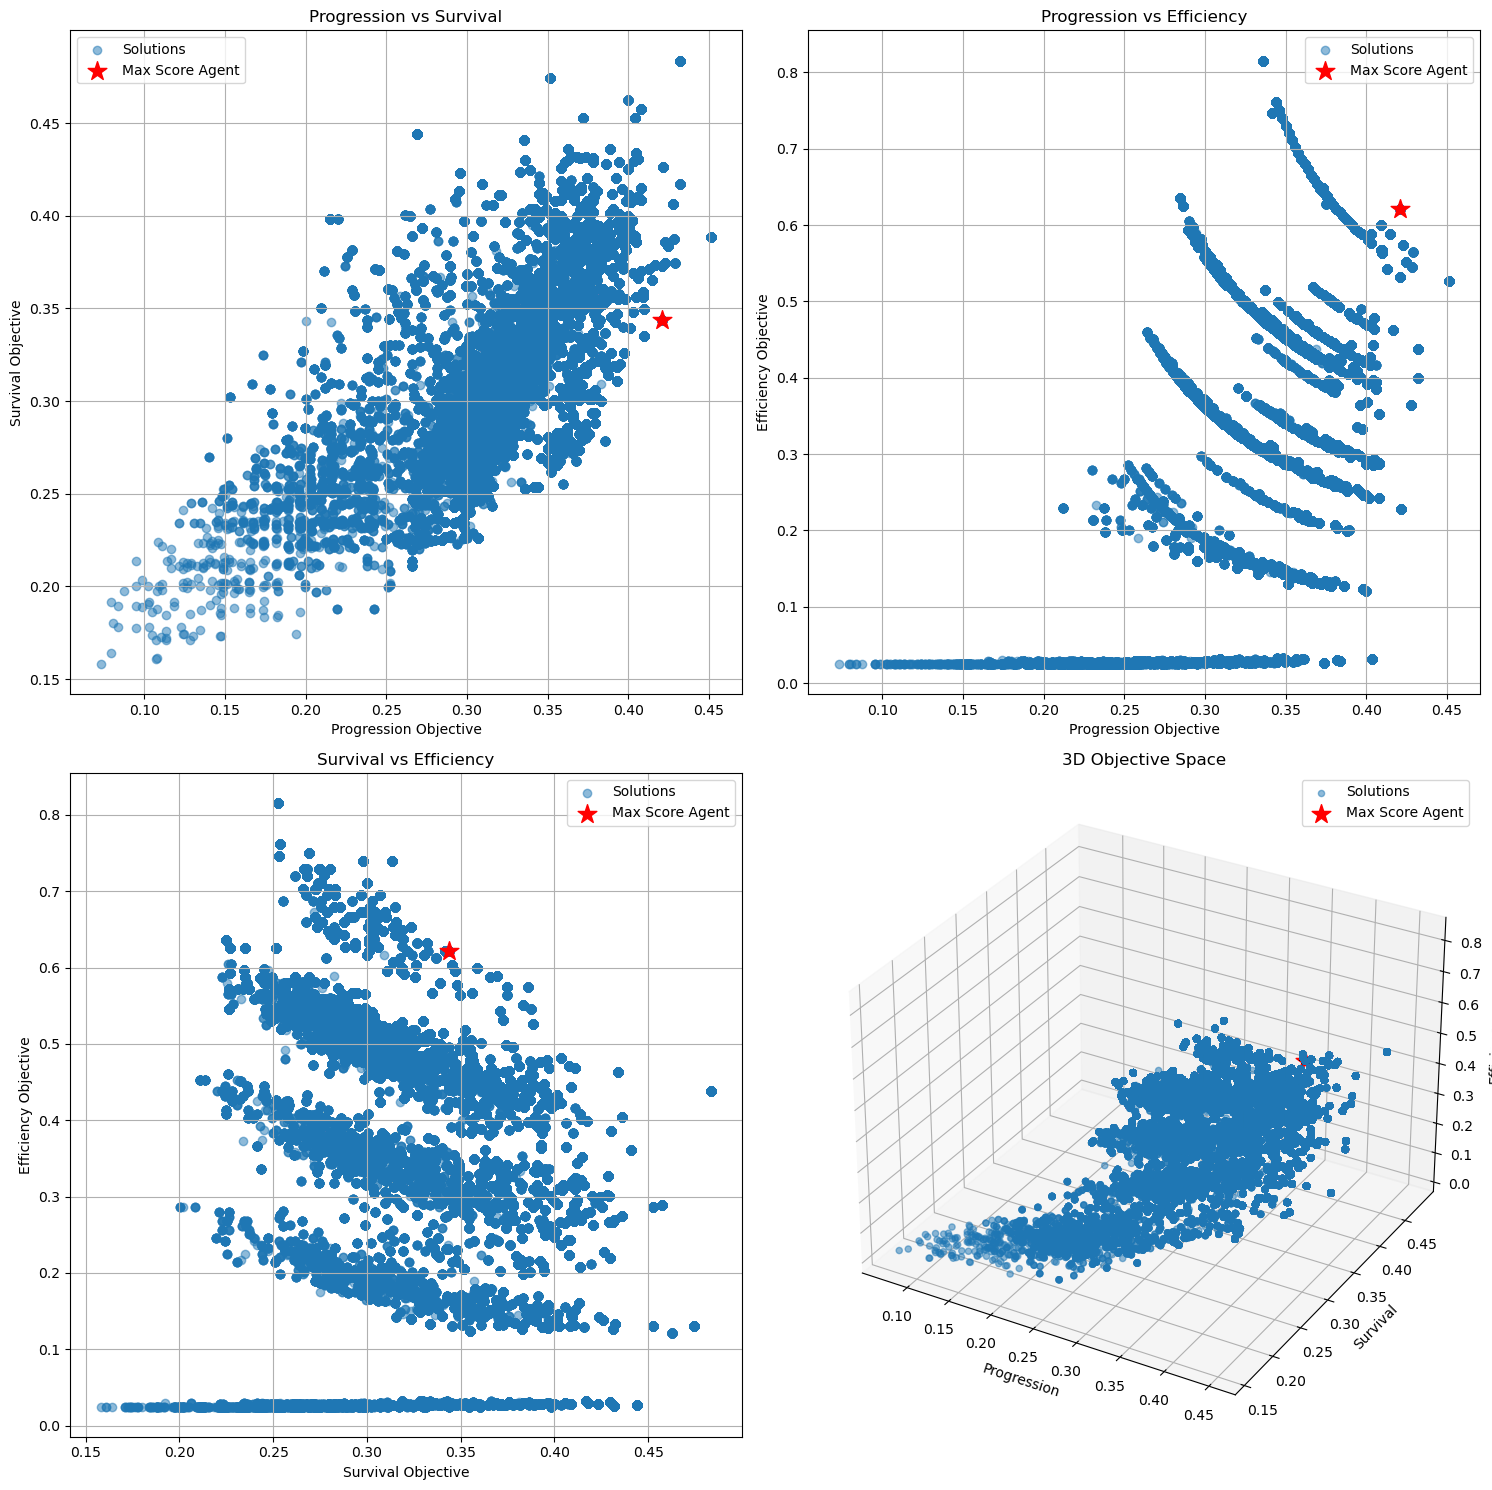


Max Score Agent Statistics:
------------------------------
Game Score: 4170.0
Generation: 867
Playstyle: Hunter

Objective Values:
Progression: 0.421
Survival: 0.344
Efficiency: 0.621

Percentile Rankings:
Progression: 98.9th percentile
Survival: 51.1th percentile
Efficiency: 87.7th percentile
Max Score Agent Analysis
Generation Found: 867
Total Score: 4170.0
Playstyle: Hunter

Detailed Metrics:
Frames Survived: 3889
Deaths: 3
Ghost Points: 3600.0
Pellet Points: 570.0
Scoring Actions: 55
Longest Scoring Streak: 1
Final Lives: 0

Scoring Distribution:
Ghost Points: 86.3%
Pellet Points: 13.7%


In [26]:
# Pareto analysis
def get_visualisation_data(results):
    """Extract data needed for visualization from results"""
    all_solutions = []
    
    # Get data from results
    for gen_data in results['generation_history']:
        if 'objective_values' in gen_data:
            for obj_vals in gen_data['objective_values']:
                all_solutions.append({
                    'progression': obj_vals[0],
                    'survival': obj_vals[1],
                    'efficiency': obj_vals[2]
                })
    
    # Get max score agent directly from results
    max_score_point = None
    if 'performance_metrics' in results and 'max_score_agent' in results['performance_metrics']:
        max_agent = results['performance_metrics']['max_score_agent']
        if max_agent['fitness_values'] is not None:
            max_score_point = {
                'progression': max_agent['fitness_values'][0],
                'survival': max_agent['fitness_values'][1],
                'efficiency': max_agent['fitness_values'][2],
                'score': max_agent['total_score'],
                'generation': max_agent['generation'],
                'playstyle': max_agent['playstyle']
            }
    
    return all_solutions, max_score_point

def calculate_percentile_rank(value, array):
    """Calculate the percentile rank of a value in an array"""
    return (array < value).mean() * 100

def plot_pareto_analysis(results):
    """Create comprehensive Pareto front visualisation with max score statistics"""
    all_solutions, max_score_point = get_visualisation_data(results)
    
    # Convert to numpy arrays for easier plotting
    objectives = np.array([[s['progression'], s['survival'], s['efficiency']] 
                          for s in all_solutions])
    
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 15))
    
    # 2D Projections
    # Progression vs Survival
    ax1 = fig.add_subplot(221)
    ax1.scatter(objectives[:, 0], objectives[:, 1], alpha=0.5, label='Solutions')
    if max_score_point:
        ax1.scatter(max_score_point['progression'], max_score_point['survival'], 
                   color='red', marker='*', s=200, label='Max Score Agent')
    ax1.set_xlabel('Progression Objective')
    ax1.set_ylabel('Survival Objective')
    ax1.set_title('Progression vs Survival')
    ax1.legend()
    ax1.grid(True)
    
    # Progression vs Efficiency
    ax2 = fig.add_subplot(222)
    ax2.scatter(objectives[:, 0], objectives[:, 2], alpha=0.5, label='Solutions')
    if max_score_point:
        ax2.scatter(max_score_point['progression'], max_score_point['efficiency'], 
                   color='red', marker='*', s=200, label='Max Score Agent')
    ax2.set_xlabel('Progression Objective')
    ax2.set_ylabel('Efficiency Objective')
    ax2.set_title('Progression vs Efficiency')
    ax2.legend()
    ax2.grid(True)
    
    # Survival vs Efficiency
    ax3 = fig.add_subplot(223)
    ax3.scatter(objectives[:, 1], objectives[:, 2], alpha=0.5, label='Solutions')
    if max_score_point:
        ax3.scatter(max_score_point['survival'], max_score_point['efficiency'], 
                   color='red', marker='*', s=200, label='Max Score Agent')
    ax3.set_xlabel('Survival Objective')
    ax3.set_ylabel('Efficiency Objective')
    ax3.set_title('Survival vs Efficiency')
    ax3.legend()
    ax3.grid(True)
    
    # 3D Plot
    ax4 = fig.add_subplot(224, projection='3d')
    scatter = ax4.scatter(objectives[:, 0], objectives[:, 1], objectives[:, 2], 
                         alpha=0.5, label='Solutions')
    if max_score_point:
        ax4.scatter(max_score_point['progression'], max_score_point['survival'], 
                   max_score_point['efficiency'], color='red', marker='*', 
                   s=200, label='Max Score Agent')
    ax4.set_xlabel('Progression')
    ax4.set_ylabel('Survival')
    ax4.set_zlabel('Efficiency')
    ax4.set_title('3D Objective Space')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics about max score agent
    if max_score_point:
        print("\nMax Score Agent Statistics:")
        print("-" * 30)
        print(f"Game Score: {max_score_point['score']}")
        print(f"Generation: {max_score_point['generation']}")
        print(f"Playstyle: {max_score_point['playstyle']['playstyle']}")
        print(f"\nObjective Values:")
        print(f"Progression: {max_score_point['progression']:.3f}")
        print(f"Survival: {max_score_point['survival']:.3f}")
        print(f"Efficiency: {max_score_point['efficiency']:.3f}")
        
        # Calculate percentile ranks
        prog_percentile = calculate_percentile_rank(max_score_point['progression'], objectives[:, 0])
        surv_percentile = calculate_percentile_rank(max_score_point['survival'], objectives[:, 1])
        eff_percentile = calculate_percentile_rank(max_score_point['efficiency'], objectives[:, 2])
        
        print("\nPercentile Rankings:")
        print(f"Progression: {prog_percentile:.1f}th percentile")
        print(f"Survival: {surv_percentile:.1f}th percentile")
        print(f"Efficiency: {eff_percentile:.1f}th percentile")

# For additional analysis 
def analyse_max_score_agent(results):
    """Detailed analysis of the max score agent's performance"""
    if 'performance_metrics' not in results or 'max_score_agent' not in results['performance_metrics']:
        print("No max score agent data found in results")
        return
        
    max_agent = results['performance_metrics']['max_score_agent']
    metrics = max_agent['metrics']
    
    print("Max Score Agent Analysis")
    print("=" * 50)
    print(f"Generation Found: {max_agent['generation']}")
    print(f"Total Score: {max_agent['total_score']}")
    print(f"Playstyle: {max_agent['playstyle']['playstyle']}")
    
    if metrics:
        print("\nDetailed Metrics:")
        print(f"Frames Survived: {metrics['frames_survived']}")
        print(f"Deaths: {metrics['deaths']}")
        print(f"Ghost Points: {metrics['ghost_points']}")
        print(f"Pellet Points: {metrics['pellet_points']}")
        print(f"Scoring Actions: {metrics['scoring_actions']}")
        print(f"Longest Scoring Streak: {metrics['longest_scoring_streak']}")
        print(f"Final Lives: {metrics['current_lives']}")
        
        # Calculate scoring distribution
        total_points = metrics['ghost_points'] + metrics['pellet_points']
        if total_points > 0:
            ghost_percentage = (metrics['ghost_points'] / total_points) * 100
            pellet_percentage = (metrics['pellet_points'] / total_points) * 100
            print(f"\nScoring Distribution:")
            print(f"Ghost Points: {ghost_percentage:.1f}%")
            print(f"Pellet Points: {pellet_percentage:.1f}%")
            
plot_pareto_analysis(results)

# Get detailed analysis of max score agent
analyse_max_score_agent(results)

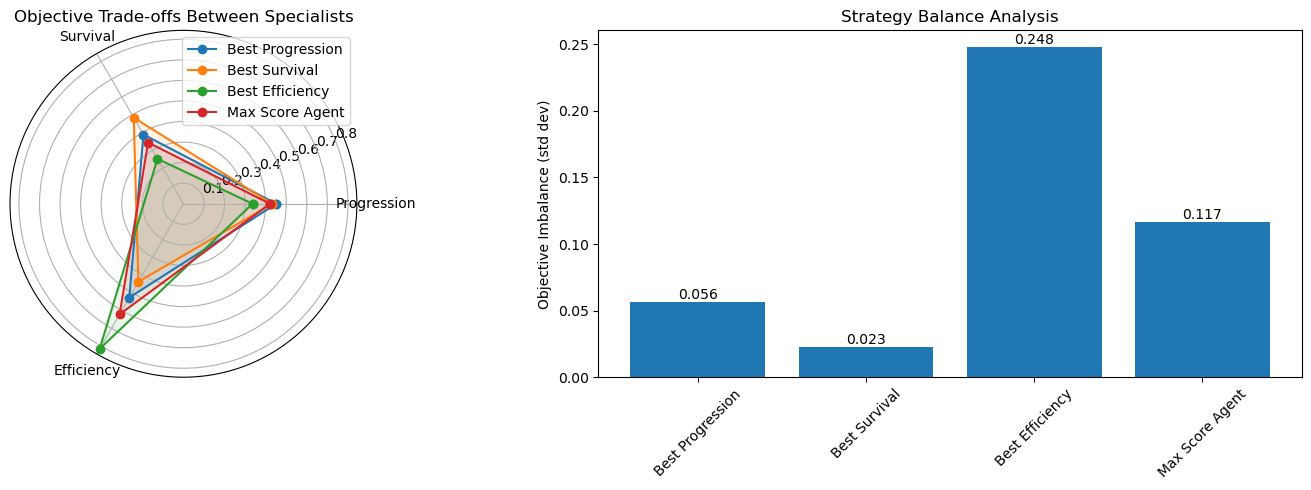


Strategy Balance Analysis:
------------------------------

Best Progression:
Mean Objective Value: 0.456
Objective Spread: 0.138
Balance Metric (std): 0.056

Best Survival:
Mean Objective Value: 0.451
Objective Spread: 0.052
Balance Metric (std): 0.023

Best Efficiency:
Mean Objective Value: 0.468
Objective Spread: 0.563
Balance Metric (std): 0.248

Max Score Agent:
Mean Objective Value: 0.462
Objective Spread: 0.277
Balance Metric (std): 0.117


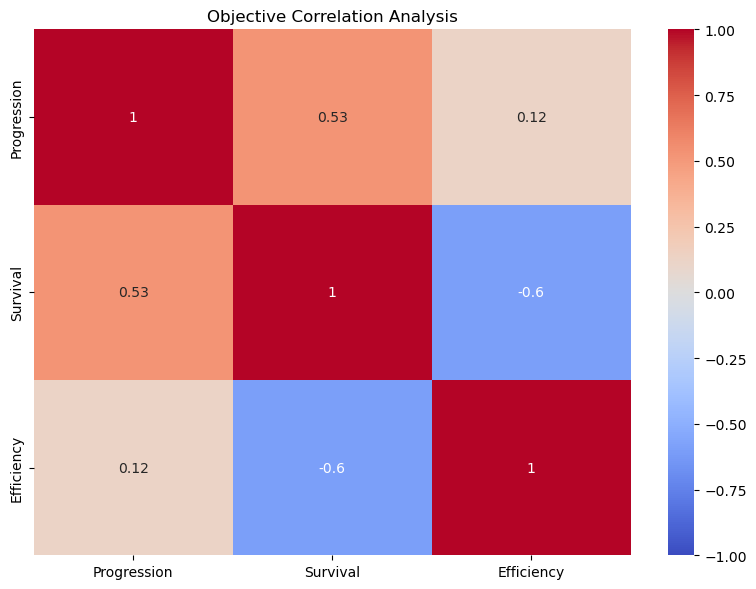


Objective Correlation Analysis:
------------------------------
Progression vs Survival: 0.529
Progression vs Efficiency: 0.122
Survival vs Efficiency: -0.596


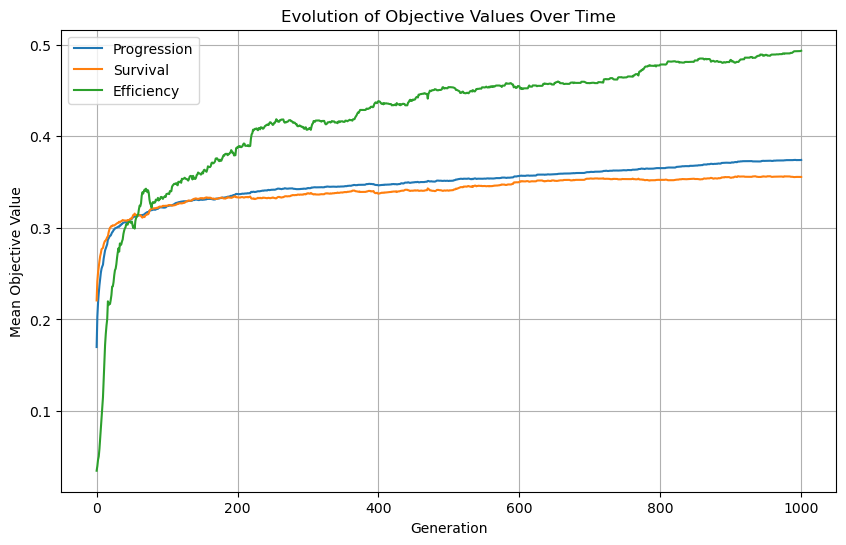

In [27]:
def analyse_objective_trade_offs(results, all_solutions, max_score_point):
    """Analyse how the max_score_agent balances objectives compared to specialists"""
    
    # Get best agents for each objective
    objectives = np.array([[s['progression'], s['survival'], s['efficiency']] 
                          for s in all_solutions])
    
    best_progression_idx = np.argmax(objectives[:, 0])
    best_survival_idx = np.argmax(objectives[:, 1])
    best_efficiency_idx = np.argmax(objectives[:, 2])
    
    specialists = {
        'Best Progression': objectives[best_progression_idx],
        'Best Survival': objectives[best_survival_idx],
        'Best Efficiency': objectives[best_efficiency_idx],
        'Max Score Agent': np.array([
            max_score_point['progression'],
            max_score_point['survival'],
            max_score_point['efficiency']
        ])
    }
    
    # Create radar plot comparing specialists with max_score_agent
    fig = plt.figure(figsize=(15, 5))
    
    # Radar Plot
    ax1 = fig.add_subplot(121, projection='polar')
    
    # Set up the angles for the radar plot
    angles = np.linspace(0, 2*np.pi, 3, endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))  
    
    for agent_name, values in specialists.items():
        values = np.concatenate((values, [values[0]]))  
        ax1.plot(angles, values, '-o', label=agent_name)
        ax1.fill(angles, values, alpha=0.1)
    
    ax1.set_xticks(angles[:-1])
    ax1.set_xticklabels(['Progression', 'Survival', 'Efficiency'])
    ax1.set_title('Objective Trade-offs Between Specialists')
    ax1.legend()

    # Create balance metric plot
    ax2 = fig.add_subplot(122)
    
    # Calculate balance metrics (standard deviation of normalised objectives)
    balance_metrics = {}
    for name, values in specialists.items():
        balance_metrics[name] = np.std(values)
    
    # Plot balance metrics
    names = list(balance_metrics.keys())
    values = list(balance_metrics.values())
    
    bars = ax2.bar(names, values)
    ax2.set_ylabel('Objective Imbalance (std dev)')
    ax2.set_title('Strategy Balance Analysis')
    plt.xticks(rotation=45)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Print additional analysis
    print("\nStrategy Balance Analysis:")
    print("-" * 30)
    for name, values in specialists.items():
        mean_obj = np.mean(values)
        std_obj = np.std(values)
        min_obj = np.min(values)
        max_obj = np.max(values)
        print(f"\n{name}:")
        print(f"Mean Objective Value: {mean_obj:.3f}")
        print(f"Objective Spread: {max_obj - min_obj:.3f}")
        print(f"Balance Metric (std): {std_obj:.3f}")

def plot_objective_correlations(all_solutions):
    """Analyse correlations between objectives"""
    objectives = np.array([[s['progression'], s['survival'], s['efficiency']] 
                          for s in all_solutions])
    
    # Calculate correlation matrix
    corr_matrix = np.corrcoef(objectives.T)
    
    # Plot correlation heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, 
                annot=True, 
                xticklabels=['Progression', 'Survival', 'Efficiency'],
                yticklabels=['Progression', 'Survival', 'Efficiency'],
                cmap='coolwarm',
                vmin=-1, vmax=1)
    plt.title('Objective Correlation Analysis')
    plt.tight_layout()
    plt.show()
    
    print("\nObjective Correlation Analysis:")
    print("-" * 30)
    labels = ['Progression', 'Survival', 'Efficiency']
    for i in range(3):
        for j in range(i+1, 3):
            print(f"{labels[i]} vs {labels[j]}: {corr_matrix[i,j]:.3f}")

def analyse_temporal_evolution(results):
    """Analyse how objective values evolved over generations"""
    generation_means = []
    for gen_data in results['generation_history']:
        if 'objective_values' in gen_data:
            objectives = np.array(gen_data['objective_values'])
            generation_means.append(np.mean(objectives, axis=0))
    
    generation_means = np.array(generation_means)
    
    plt.figure(figsize=(10, 6))
    generations = range(len(generation_means))
    plt.plot(generations, generation_means[:, 0], label='Progression')
    plt.plot(generations, generation_means[:, 1], label='Survival')
    plt.plot(generations, generation_means[:, 2], label='Efficiency')
    plt.xlabel('Generation')
    plt.ylabel('Mean Objective Value')
    plt.title('Evolution of Objective Values Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run all analyses
all_solutions, max_score_point = get_visualisation_data(results)
analyse_objective_trade_offs(results, all_solutions, max_score_point)
plot_objective_correlations(all_solutions)
analyse_temporal_evolution(results)

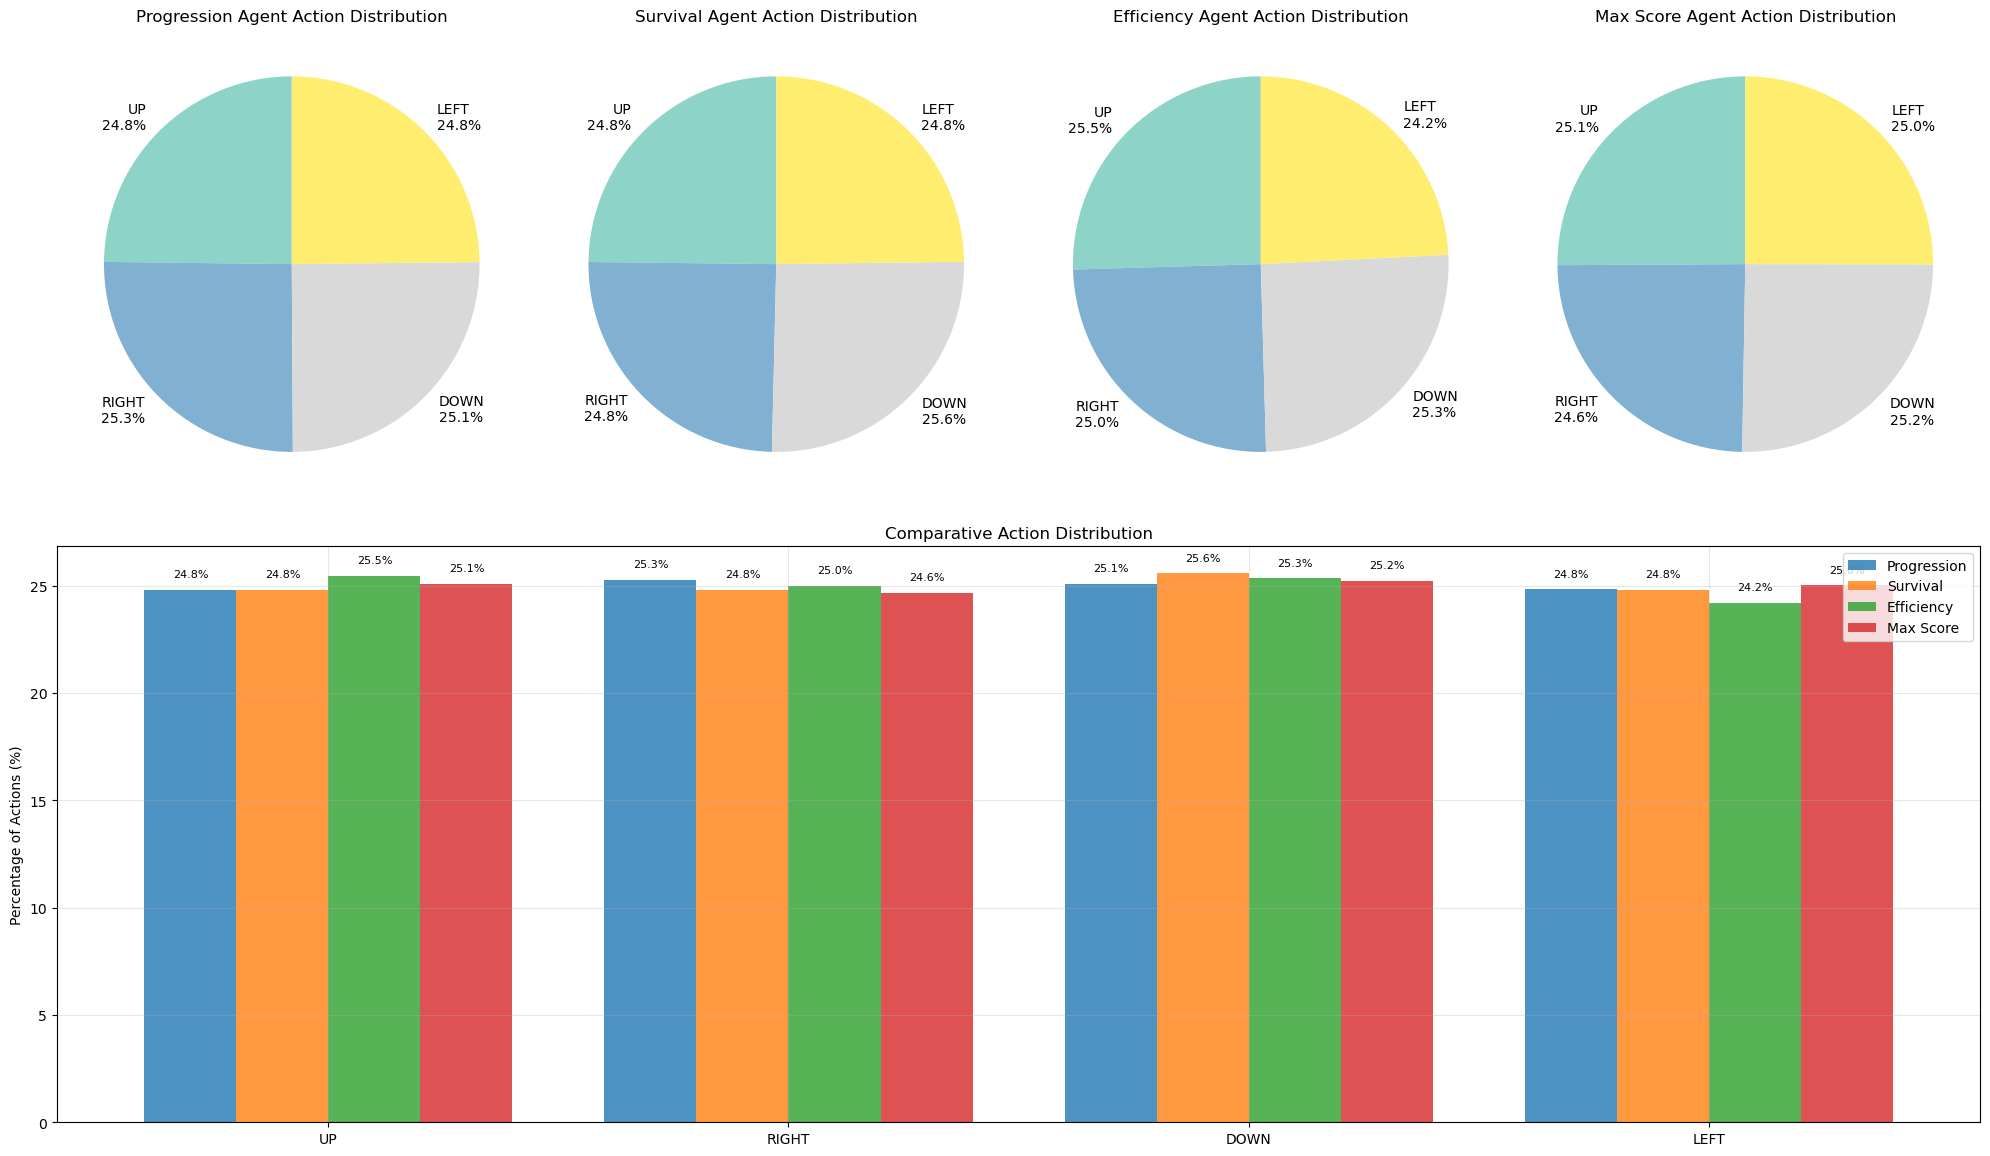


Detailed Action Distribution Comparison:
--------------------------------------------------

UP:
Progression: 24.8%
Survival: 24.8%
Efficiency: 25.5%
Max Score: 25.1%

RIGHT:
Progression: 25.3%
Survival: 24.8%
Efficiency: 25.0%
Max Score: 24.6%

DOWN:
Progression: 25.1%
Survival: 25.6%
Efficiency: 25.3%
Max Score: 25.2%

LEFT:
Progression: 24.8%
Survival: 24.8%
Efficiency: 24.2%
Max Score: 25.0%

Comparative Analysis:
--------------------------------------------------

Progression Agent:
Most used actions:
  RIGHT: 25.3%
  DOWN: 25.1%
  LEFT: 24.8%

Survival Agent:
Most used actions:
  DOWN: 25.6%
  UP: 24.8%
  RIGHT: 24.8%

Efficiency Agent:
Most used actions:
  UP: 25.5%
  DOWN: 25.3%
  RIGHT: 25.0%

Max Score Agent:
Most used actions:
  DOWN: 25.2%
  UP: 25.1%
  LEFT: 25.0%


In [28]:
# Action Distribution Analysis
# Compare action distributions across specialists and max score agent
fig = plt.figure(figsize=(20, 12))  
gs = plt.GridSpec(2, 4)  

specialists = ['Progression', 'Survival', 'Efficiency', 'Max Score']
specialist_data = [
    progression_data[0], 
    survival_data[0], 
    efficiency_data[0],
    results['performance_metrics']['max_score_agent']['individual']
]
colors = plt.cm.Set3(np.linspace(0, 1, len(action_names)))

# Store percentages for comparative bar chart
all_percentages = []

# Create pie charts
for i, (specialist, data) in enumerate(zip(specialists, specialist_data)):
    plt.subplot(gs[0, i])
    action_counts, percentages = analyse_action_distribution(data)
    all_percentages.append(list(percentages.values()))
    
    plt.pie(action_counts.values(), 
            labels=[f"{action}\n{pct:.1f}%" for action, pct in percentages.items()],
            colors=colors,
            autopct='',
            startangle=90)
    plt.title(f"{specialist} Agent Action Distribution")

# Create comparative bar chart
ax_bar = plt.subplot(gs[1, :])
x = np.arange(len(action_names))
width = 0.2  

for i, (specialist, percentages) in enumerate(zip(specialists, all_percentages)):
    ax_bar.bar(x + i*width, percentages, width, 
               label=specialist, alpha=0.8)

# Customise bar chart
ax_bar.set_ylabel('Percentage of Actions (%)')
ax_bar.set_title('Comparative Action Distribution')
ax_bar.set_xticks(x + width*1.5)  # Adjusted for 4 bars
ax_bar.set_xticklabels(action_names.values())
ax_bar.legend()
ax_bar.grid(True, alpha=0.3)

# Add percentage labels on the bars
for i, percentages in enumerate(all_percentages):
    for j, v in enumerate(percentages):
        ax_bar.text(j + i*width, v + 0.5, f'{v:.1f}%', 
                   ha='center', va='bottom',
                   fontsize=8)

plt.tight_layout()
plt.show()

# Print detailed comparison
print("\nDetailed Action Distribution Comparison:")
print("-" * 50)
for action in action_names.values():
    print(f"\n{action}:")
    for specialist, percentages in zip(specialists, all_percentages):
        idx = list(action_names.values()).index(action)
        print(f"{specialist}: {percentages[idx]:.1f}%")

# Print summary statistics
print("\nComparative Analysis:")
print("-" * 50)
for specialist, data in zip(specialists, specialist_data):
    action_counts, percentages = analyse_action_distribution(data)
    print(f"\n{specialist} Agent:")
    print("Most used actions:")
    sorted_actions = sorted(percentages.items(), key=lambda x: x[1], reverse=True)
    for action, pct in sorted_actions[:3]:
        print(f"  {action}: {pct:.1f}%")

In [29]:
print("Available fields in max_score_metrics:")
for key in max_score_metrics.keys():
    print(f"  - {key}")

Available fields in max_score_metrics:
  - total_score
  - frames_survived
  - deaths
  - score_segments
  - ghost_points
  - pellet_points
  - scoring_actions
  - total_points_from_actions
  - longest_scoring_streak
  - current_lives
  - score_change_frames
  - seed


In [30]:
print("Example metrics from Progression specialist:")
for key in metrics.keys():
    print(f"  - {key}: {type(metrics[key])}")

print("\nProgression stats structure:")
print(progression_stats.columns.tolist())

Example metrics from Progression specialist:
  - total_score: <class 'float'>
  - frames_survived: <class 'int'>
  - deaths: <class 'int'>
  - score_segments: <class 'list'>
  - ghost_points: <class 'float'>
  - pellet_points: <class 'float'>
  - scoring_actions: <class 'int'>
  - total_points_from_actions: <class 'float'>
  - longest_scoring_streak: <class 'int'>
  - current_lives: <class 'int'>
  - score_change_frames: <class 'list'>
  - seed: <class 'int'>

Progression stats structure:
['episode', 'total_reward', 'steps', 'time', 'return', 'ghost_points', 'pellet_points', 'length', 'lives', 'episode_frame_number', 'frame_number']


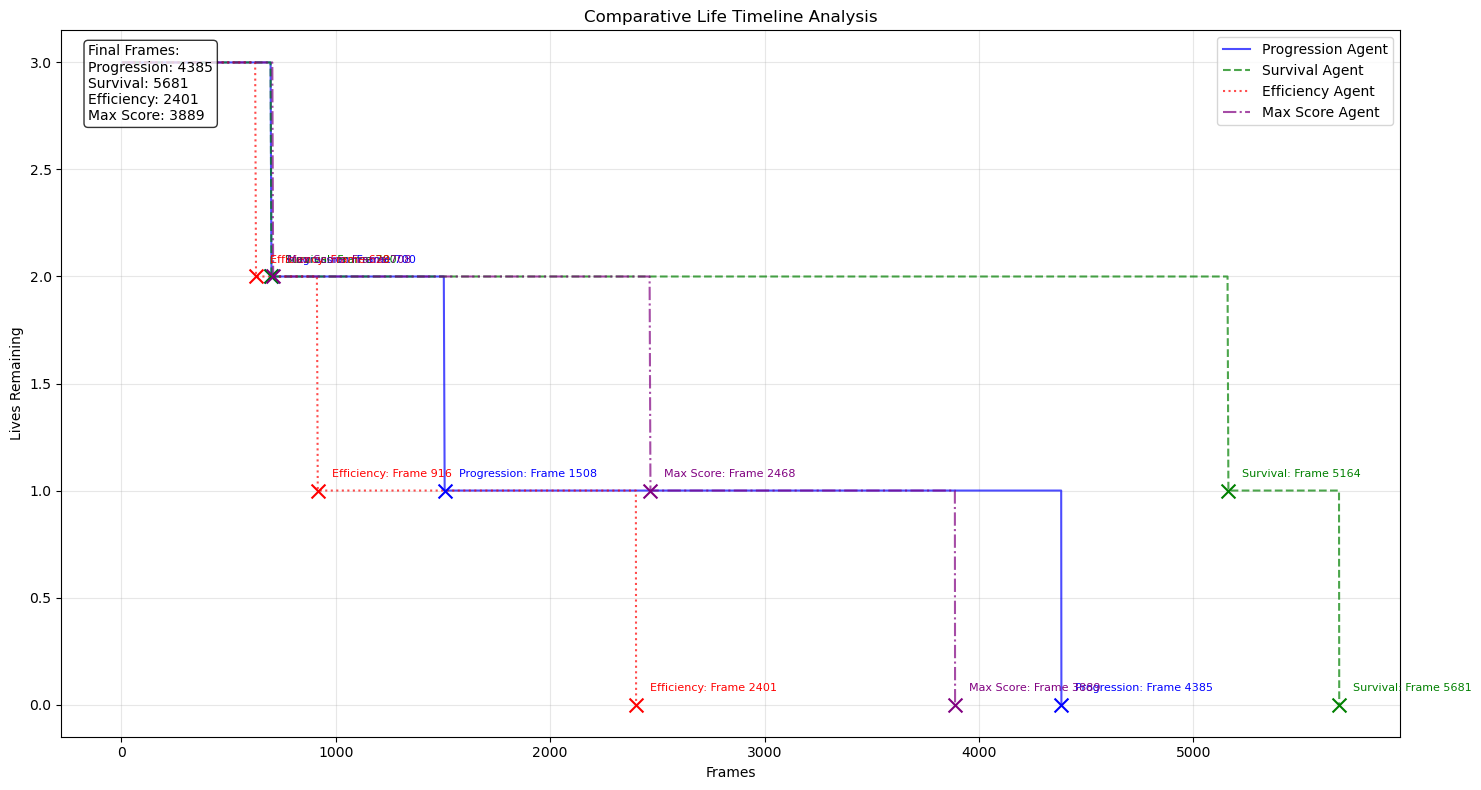

In [31]:
#rerun episode to use RecordEpisodeStatistics to get lives lost frames for overall comparative life timeline analysis
def get_max_score_episode_stats(max_score_agent, n_episodes=1):
    """Get frame-by-frame statistics for max score agent"""
    base_env = gym.make("ALE/MsPacman-v5", render_mode=None)  
    env = RecordEpisodeStatistics(base_env)
    LIMITED_ACTIONS = [1, 2, 3, 4]
    
    max_score_individual = max_score_agent['individual']
    max_score_seed = max_score_agent['seed']
    
    episode_stats = []
    specific_keys = ['lives', 'episode_frame_number', 'frame_number']
    
    for episode in range(n_episodes):
        observation, info = env.reset(seed=max_score_seed)
        env.action_space.seed(max_score_seed)
        total_reward = 0
        ghost_points = 0
        pellet_points = 0
        steps = 0
        
        terminated = False
        truncated = False
        episode_info = {key: [] for key in specific_keys}
        
        while not (terminated or truncated):
            action_idx = max_score_individual[steps % len(max_score_individual)] % len(LIMITED_ACTIONS)
            action = LIMITED_ACTIONS[action_idx]
            
            observation, reward, terminated, truncated, info = env.step(action)
            
            for key in specific_keys:
                if key in info:
                    episode_info[key].append(info[key])
            
            if reward >= 200:  # Ghost points
                ghost_points += reward
            elif reward > 0:
                pellet_points += reward
            
            total_reward += reward
            steps += 1
        
        episode_stats.append({
            'episode': episode + 1,
            'total_reward': total_reward,
            'steps': steps,
            'ghost_points': ghost_points,
            'pellet_points': pellet_points,
            'time': env.time_queue[-1] if len(env.time_queue) > 0 else None,
            'return': env.return_queue[-1] if len(env.return_queue) > 0 else None,
            'length': env.length_queue[-1] if len(env.length_queue) > 0 else None,
            **{key: episode_info[key] for key in specific_keys}
        })
    
    env.close()
    return pd.DataFrame(episode_stats)

# Get max score stats in same format as specialists
max_score_stats = get_max_score_episode_stats(results['performance_metrics']['max_score_agent'])

# Create the life timeline plot
plt.figure(figsize=(15, 8))

specialists_data = [
    (progression_stats.iloc[0], 'Progression', 'blue', '-'),
    (survival_stats.iloc[0], 'Survival', 'green', '--'),
    (efficiency_stats.iloc[0], 'Efficiency', 'red', ':'),
    (max_score_stats.iloc[0], 'Max Score', 'purple', '-.')
]

for info_dict, name, color, style in specialists_data:
    lives = info_dict.get('lives', [])
    frames = info_dict.get('frame_number', [])
    
    if len(lives) > 0 and len(frames) > 0:  # Only plot if there is data
        # Plot life line
        plt.plot(frames, lives, color=color, linestyle=style, label=f'{name} Agent', alpha=0.7)
        
        # Plot life loss events
        life_loss_events = analyse_life_losses(info_dict)
        if life_loss_events:
            loss_frames = [event['frame'] for event in life_loss_events]
            loss_lives = [event['lives_remaining'] for event in life_loss_events]
            plt.scatter(loss_frames, loss_lives, color=color, s=100, 
                       marker='x', zorder=5)
            
            # Add annotations for life loss events
            for event in life_loss_events:
                plt.annotate(f'{name}: Frame {event["frame"]}',
                            (event['frame'], event['lives_remaining']),
                            xytext=(10, 10), textcoords='offset points',
                            color=color, fontsize=8)

plt.title("Comparative Life Timeline Analysis")
plt.xlabel("Frames")
plt.ylabel("Lives Remaining")
plt.grid(True, alpha=0.3)
plt.legend()

# Add summary statistics in text box
textstr = '\n'.join([
    'Final Frames:',
    f'Progression: {progression_stats.iloc[0]["frame_number"][-1]}',
    f'Survival: {survival_stats.iloc[0]["frame_number"][-1]}',
    f'Efficiency: {efficiency_stats.iloc[0]["frame_number"][-1]}',
    f'Max Score: {max_score_stats.iloc[0]["frame_number"][-1]}'
])

plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.tight_layout()
plt.show()